# Semesterprojekt: Vorhersage von Immobilienpreisen in Berlin 
In diesem Projekt beschäftige ich mich mit der Real Live Frage, wie sich die Immobilienpreise in den Berliner Bezirken in Zukunft ändern könnten. 
Was für demografische oder ökonomische Faktoren könnten einen Einfluss auf die Preisentwicklung darstellen?
Hierzu betrachten wir die Indexentwicklung des GREIX (German Real Estate Index) für dreizehn Berliner Bezirke von 1984 bis 2022. Des Weiteren betrachten wir als Feature-Erweiterung die Geburtenraten und die Baufertigstellungen in den jeweiligen Bezirken. Diese Betrachtungen sollen den GREIX Datensatz ergänzen und es soll untersucht werden, inwiefern sie den Indexwert beeinflussen. 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Untersuchung des GREIX Datensatz
Der Immobilienpreisindex der verschiedenen Bezirke soll untersucht werden um einen tieferen Einblich in den Datensatz zu gewinnen.

In [4]:
dsg = pd.read_excel('data_greix_original.xlsx')
dsg.head(20)

,year,Berlin (Südwest),Berlin (Charlottenburg),Berlin (Nord),Berlin (Mitte),Berlin (Süd-Ost),Berlin (Wedding - Gesundbrunnen),Berlin (Schöneberg - Friedenau),Berlin (Wilmersdorf),Berlin (Prenzlauerberg),Berlin (Ost),Berlin (Friedrichshain),Berlin (West),Berlin (Tempelhof - Neukölln - Kreuzberg)
0,1984,91.132989,79.539973,120.376104,NaN,103.921758,89.226200,79.578184,84.497013,NaN,NaN,NaN,127.351488,93.844733
1,1985,88.548005,72.551961,112.550437,NaN,95.792847,92.226241,77.114439,82.725596,NaN,NaN,NaN,116.107160,78.390999
2,1986,91.507428,73.609518,112.130357,NaN,95.797092,95.555277,70.360043,85.568244,NaN,NaN,NaN,117.103016,87.968422
3,1987,93.415040,74.086593,110.504014,NaN,97.322275,95.743388,75.370410,71.214226,NaN,NaN,NaN,104.654059,81.887607
4,1988,94.026135,80.134564,118.634475,NaN,96.025480,97.280110,74.184455,82.051677,NaN,NaN,NaN,122.845948,75.514628
5,1989,104.402463,85.885503,119.301812,NaN,105.558626,100.634011,87.724331,93.389635,NaN,NaN,NaN,114.828874,86.749946
6,1990,121.234925,97.749865,138.118935,NaN,123.706568,129.607202,108.845606,112.983861,NaN,NaN,NaN,135.411904,113.722496
7,1991,141.066460,130.265613,148.451823,NaN,144.837860,154.254761,122.641585,138.598755,NaN,NaN,NaN,159.858400,146.821939
8,1992,147.919896,137.628413,174.562982,NaN,152.423846,166.948407,143.853545,145.764431,NaN,NaN,NaN,173.886637,147.900748
9,1993,146.088314,133.313573,166.056053,NaN,152.283424,156.638647,135.584597,142.982027,NaN,NaN,NaN,172.991249,145.658731


In [260]:
dsg.shape

(39, 14)

In [259]:
dsg.describe()

,year,Berlin (Südwest),Berlin (Charlottenburg),Berlin (Nord),Berlin (Mitte),Berlin (Süd-Ost),Berlin (Wedding - Gesundbrunnen),Berlin (Schöneberg - Friedenau),Berlin (Wilmersdorf),Berlin (Prenzlauerberg),Berlin (Ost),Berlin (Friedrichshain),Berlin (West),Berlin (Tempelhof - Neukölln - Kreuzberg)
count,39.000000,39.000000,39.000000,39.000000,26.000000,39.000000,39.000000,39.000000,39.000000,26.000000,29.000000,28.000000,39.000000,39.000000
mean,2003.000000,113.733133,120.696606,124.073059,135.559559,116.146552,130.433572,119.973910,124.138152,135.647271,113.148721,128.898236,119.847129,135.322248
std,11.401754,37.392830,53.547868,39.026402,54.765867,33.501540,55.351860,49.551732,49.293106,56.848024,41.418881,51.731516,37.957148,70.794907
min,1984.000000,73.409820,72.551961,79.061093,81.860290,78.301752,73.872597,70.360043,71.214226,90.231129,71.893213,85.017607,71.518977,75.514628
25%,1993.500000,87.827307,82.051904,91.181362,97.588842,94.020829,90.368523,82.707953,87.531077,96.464968,74.993186,93.851282,86.571682,85.886286
50%,2003.000000,104.402463,101.802316,118.168997,108.862619,103.136393,106.405774,106.123096,108.026706,104.169558,100.108249,107.402794,116.107160,112.016807
75%,2012.500000,135.636763,131.789593,146.103389,161.269406,138.824326,154.311341,134.328917,141.476035,155.900013,134.967878,143.159804,137.545906,147.361343
max,2022.000000,212.778478,262.873231,225.436326,258.469489,208.260513,275.502360,254.684546,255.957129,263.757807,209.909666,251.492332,201.545625,326.734630


### Datentypen und Nullwerte der Variablen

In [261]:
dsg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 14 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   year                                       39 non-null     int64  
 1   Berlin (Südwest)                           39 non-null     float64
 2   Berlin (Charlottenburg)                    39 non-null     float64
 3   Berlin (Nord)                              39 non-null     float64
 4   Berlin (Mitte)                             26 non-null     float64
 5   Berlin (Süd-Ost)                           39 non-null     float64
 6   Berlin (Wedding - Gesundbrunnen)           39 non-null     float64
 7   Berlin (Schöneberg - Friedenau)            39 non-null     float64
 8   Berlin (Wilmersdorf)                       39 non-null     float64
 9   Berlin (Prenzlauerberg)                    26 non-null     float64
 10  Berlin (Ost)                

In [262]:
dsg.isna().sum()

year                                          0
Berlin (Südwest)                              0
Berlin (Charlottenburg)                       0
Berlin (Nord)                                 0
Berlin (Mitte)                               13
Berlin (Süd-Ost)                              0
Berlin (Wedding - Gesundbrunnen)              0
Berlin (Schöneberg - Friedenau)               0
Berlin (Wilmersdorf)                          0
Berlin (Prenzlauerberg)                      13
Berlin (Ost)                                 10
Berlin (Friedrichshain)                      11
Berlin (West)                                 0
Berlin (Tempelhof - Neukölln - Kreuzberg)     0
dtype: int64

### Anzeigen der einzigartigen Ausprägungen jeder Variable

In [263]:
for col in dsg.columns:
    print(col)
    print(dsg[col].unique())
    print()

year
[1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]

Berlin (Südwest)
[ 91.1329887   88.54800488  91.50742754  93.41504042  94.0261345
 104.40246257 121.23492548 141.0664601  147.91989551 146.08831357
 137.42064521 133.85288104 121.42303463 111.20965566 108.94230773
 105.63781301 100.          94.00055017  87.10660813  80.77524212
  76.86518146  73.40982044  73.77182204  74.58124016  74.99595883
  74.41261318  75.80158675  79.90812205  90.01134827  95.58018775
 105.42082605 117.95958666 131.04650883 149.34749977 159.5079728
 178.51187738 186.80157936 205.16960384 212.77847814]

Berlin (Charlottenburg)
[ 79.53997269  72.55196097  73.60951823  74.08659341  80.13456407
  85.88550259  97.74986453 130.26561331 137.6284135  133.31357335
 129.5753965  120.08245475 105.20659311 107.08991542 101.80231605
  98.61078824 100.          90.05278333  

### Datenbereinigung
Wir setzen die weitere EDA und Transformationen mit einem neuen DataFrame fort, damit wir die Originaldaten nicht verlieren. Des Weiteren ist es von Vorteil die Variablennamen anzupassen, so dass sie keine Klammern, Leerzeichen und Großbuchstaben mehr beinhalten.

In [264]:
data_greix = dsg.copy()
data_greix.columns = data_greix.columns.str.lower().str.replace(' (', '_').str.replace(')', '').str.replace(' ', '').str.replace('-', '_')
data_greix = data_greix.round(2)
data_greix.to_excel('data_greix_standardized.xlsx', index=False)
data_greix.head(20)

,year,berlin_südwest,berlin_charlottenburg,berlin_nord,berlin_mitte,berlin_süd_ost,berlin_wedding_gesundbrunnen,berlin_schöneberg_friedenau,berlin_wilmersdorf,berlin_prenzlauerberg,berlin_ost,berlin_friedrichshain,berlin_west,berlin_tempelhof_neukölln_kreuzberg
0,1984,91.13,79.54,120.38,NaN,103.92,89.23,79.58,84.50,NaN,NaN,NaN,127.35,93.84
1,1985,88.55,72.55,112.55,NaN,95.79,92.23,77.11,82.73,NaN,NaN,NaN,116.11,78.39
2,1986,91.51,73.61,112.13,NaN,95.80,95.56,70.36,85.57,NaN,NaN,NaN,117.10,87.97
3,1987,93.42,74.09,110.50,NaN,97.32,95.74,75.37,71.21,NaN,NaN,NaN,104.65,81.89
4,1988,94.03,80.13,118.63,NaN,96.03,97.28,74.18,82.05,NaN,NaN,NaN,122.85,75.51
5,1989,104.40,85.89,119.30,NaN,105.56,100.63,87.72,93.39,NaN,NaN,NaN,114.83,86.75
6,1990,121.23,97.75,138.12,NaN,123.71,129.61,108.85,112.98,NaN,NaN,NaN,135.41,113.72
7,1991,141.07,130.27,148.45,NaN,144.84,154.25,122.64,138.60,NaN,NaN,NaN,159.86,146.82
8,1992,147.92,137.63,174.56,NaN,152.42,166.95,143.85,145.76,NaN,NaN,NaN,173.89,147.90
9,1993,146.09,133.31,166.06,NaN,152.28,156.64,135.58,142.98,NaN,NaN,NaN,172.99,145.66


### Auffüllung von Nullwerten durch Imputation
Es gibt 4 Bezirke für die es Nullwerte gibt, hauptsächlich in den Jahren vor der Wende. Wir betrachten die Werte von anderen Bezirken und können ähnliche Verläufe des Immobilienpreisindexes beobachten. Daher können wir versuchen einen Ansatz zu wählen, der auf dem Verhältnis oder der Beziehung zwischen den Bezirken basiert. Dafür schauen wir uns zuerst einmal die Korrelationsmatrix der Bezirke an. 

### Korrelationsmatrix

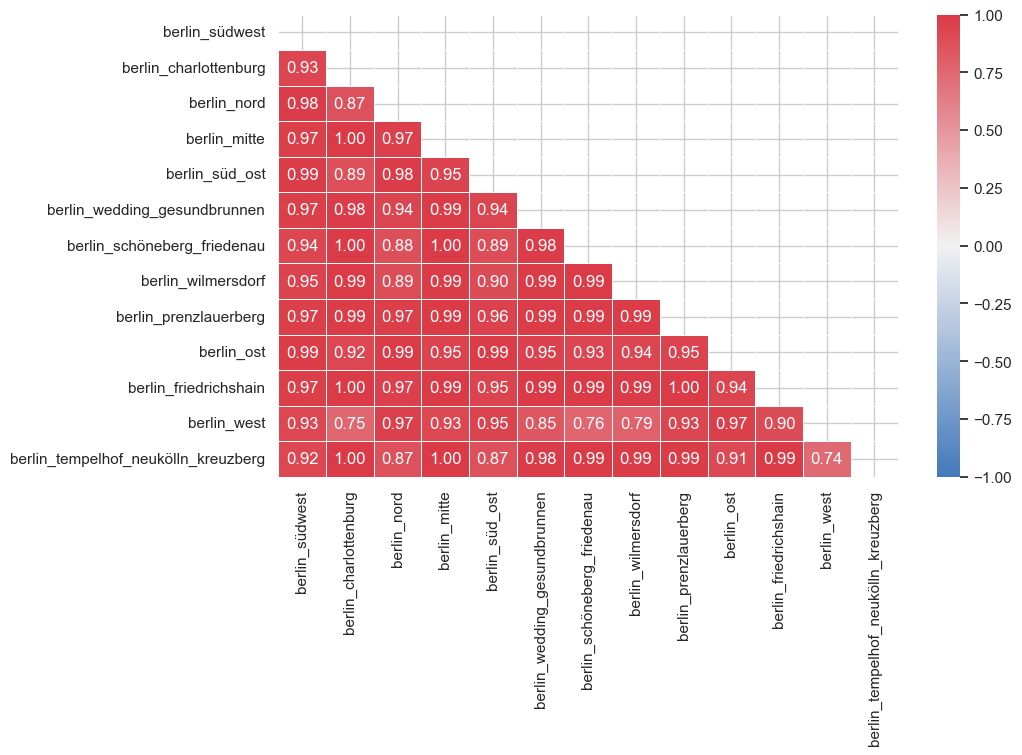

In [745]:
# Berechnung der Korrelationsmatrix
corr = data_greix.iloc[:, 1:].corr(numeric_only=True)

# Maske für das obere Dreieck
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot-Einstellungen
f, ax = plt.subplots(figsize=(10, 6))

# Anpassen der Farbpalette
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Erstellen und Anzeigen der Heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmax=1, vmin=-1, linewidths=.5, annot=True, fmt=".2f")
plt.show()

Wenn zwei Bezirke einen Wert von 1 oder nahe 1 aufweisen, deutet dies darauf hin, dass sie eine sehr starke positive Korrelation haben. Dies bedeutet, dass ihre Preisentwicklung sehr ähnlich ist und sie sich im Zeitverlauf in einem gleichförmigen Verhältnis zueinander bewegen. In einem solchen Fall können wir davon ausgehen, dass einer dieser Bezirke als Referenz für den anderen dienen kann, um fehlende Daten zu ergänzen. Wir bilden dafür das Durchschnittsverhältnis über die Jahre für die Daten verfügbar sind, und nutzen dies anschließend um die fehlenden Werte zu ergänzen. 

- Für Berlin Mitte wählen wir als Referenz: Berlin Tempelhof Neukölln Kreuzberg
- Für Berlin Prenzlauer Berg: Berlin Wedding Gesundbrunnen
- Für Berlin Friedrichshain: Berlin Charlottenburg
- Für Berlin Ost: Berlin Südost

In [148]:
# Laden der Daten
data_greix = pd.read_excel('data_greix_standardized.xlsx')

def calculate_ratio_and_impute(data, base_column, target_columns):
    for target_column in target_columns:
        # Berechnung des Durchschnittsverhältnisses zwischen den Bezirken
        ratio = data.dropna(subset=[base_column, target_column])
        average_ratio = (ratio[target_column] / ratio[base_column]).mean()

        # Imputation der fehlenden Daten
        missing_indices = data[target_column].isnull() & data[base_column].notnull()
        data.loc[missing_indices, target_column] = data.loc[missing_indices, base_column] * average_ratio

# Anwendung der Funktion
calculate_ratio_and_impute(data_greix, 'berlin_tempelhof_neukölln_kreuzberg', ['berlin_mitte'])
calculate_ratio_and_impute(data_greix, 'berlin_wedding_gesundbrunnen', ['berlin_prenzlauerberg'])
calculate_ratio_and_impute(data_greix, 'berlin_charlottenburg', ['berlin_friedrichshain'])
calculate_ratio_and_impute(data_greix, 'berlin_süd_ost', ['berlin_ost'])

# Ergebnis anzeigen
data_greix = data_greix.round(2)
data_greix.head(15)

,year,berlin_südwest,berlin_charlottenburg,berlin_nord,berlin_mitte,berlin_süd_ost,berlin_wedding_gesundbrunnen,berlin_schöneberg_friedenau,berlin_wilmersdorf,berlin_prenzlauerberg,berlin_ost,berlin_friedrichshain,berlin_west,berlin_tempelhof_neukölln_kreuzberg
0,1984,91.13,79.54,120.38,92.34,103.92,89.23,79.58,84.50,92.96,100.03,81.49,127.35,93.84
1,1985,88.55,72.55,112.55,77.14,95.79,92.23,77.11,82.73,96.09,92.20,74.33,116.11,78.39
2,1986,91.51,73.61,112.13,86.56,95.80,95.56,70.36,85.57,99.56,92.21,75.42,117.10,87.97
3,1987,93.42,74.09,110.50,80.58,97.32,95.74,75.37,71.21,99.74,93.68,75.91,104.65,81.89
4,1988,94.03,80.13,118.63,74.30,96.03,97.28,74.18,82.05,101.35,92.43,82.10,122.85,75.51
5,1989,104.40,85.89,119.30,85.36,105.56,100.63,87.72,93.39,104.84,101.61,88.00,114.83,86.75
6,1990,121.23,97.75,138.12,111.90,123.71,129.61,108.85,112.98,135.03,119.08,100.15,135.41,113.72
7,1991,141.07,130.27,148.45,144.47,144.84,154.25,122.64,138.60,160.70,139.42,133.47,159.86,146.82
8,1992,147.92,137.63,174.56,145.53,152.42,166.95,143.85,145.76,173.93,146.71,141.01,173.89,147.90
9,1993,146.09,133.31,166.06,143.33,152.28,156.64,135.58,142.98,163.19,146.58,136.58,172.99,145.66


Wir erhalten sinnvolle Werte für die imputierten Daten, daher führen wir unsere weiter Datenanalyse mit diesem ergänzten Datensatz fort.

In [149]:
data_greix.to_excel('data_greix_standardized_noNaN.xlsx', index=False)

### Verteilungen betrachten

#### Histogramme aller Bezirke

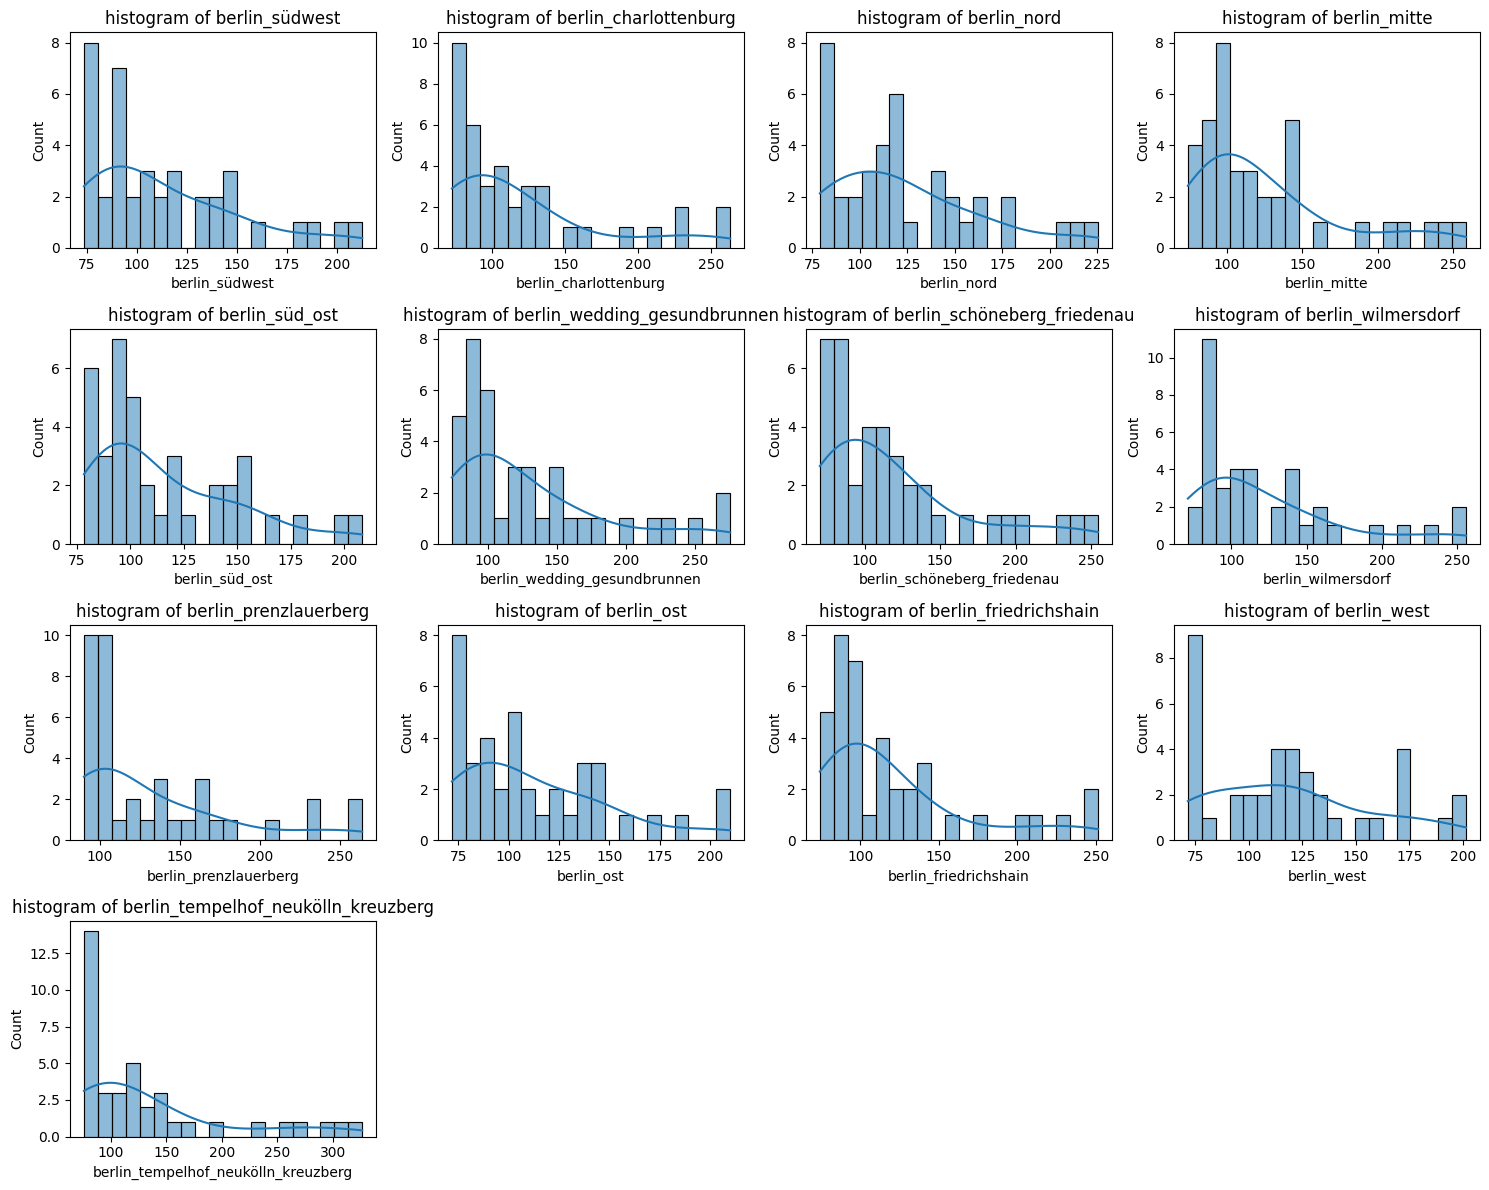

In [150]:
numerical_columns = data_greix.select_dtypes(include=['float64', 'int64']).columns.to_list()[1:]

plt.figure(figsize=(15, 12))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(4, 4, i)
    sns.histplot(data_greix[col], kde=True, bins=20)
    plt.title(f'histogram of {col}')

plt.tight_layout()
plt.show()

#### Violinplots der Verteilungen

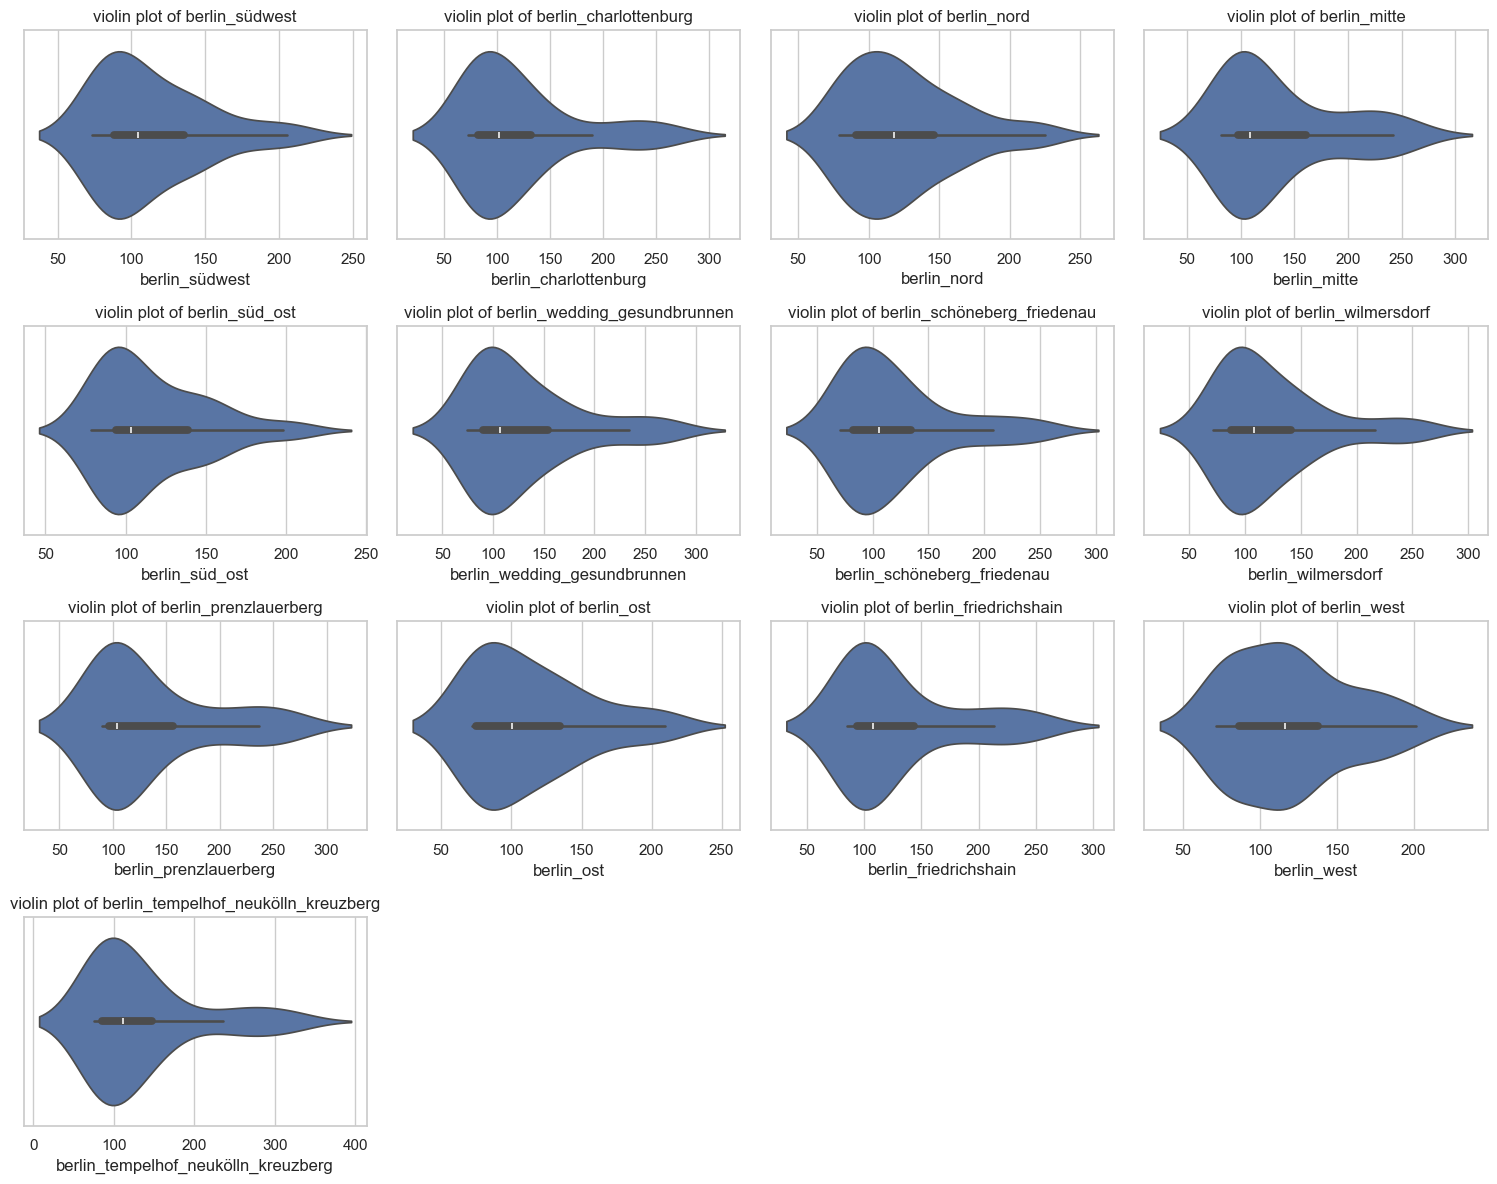

In [720]:
plt.figure(figsize=(15, 12))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(4, 4, i)
    sns.violinplot(x=data_greix[col])
    plt.title(f'violin plot of {col}')

plt.tight_layout()
plt.show()

### Outlier detection

#### Boxplots

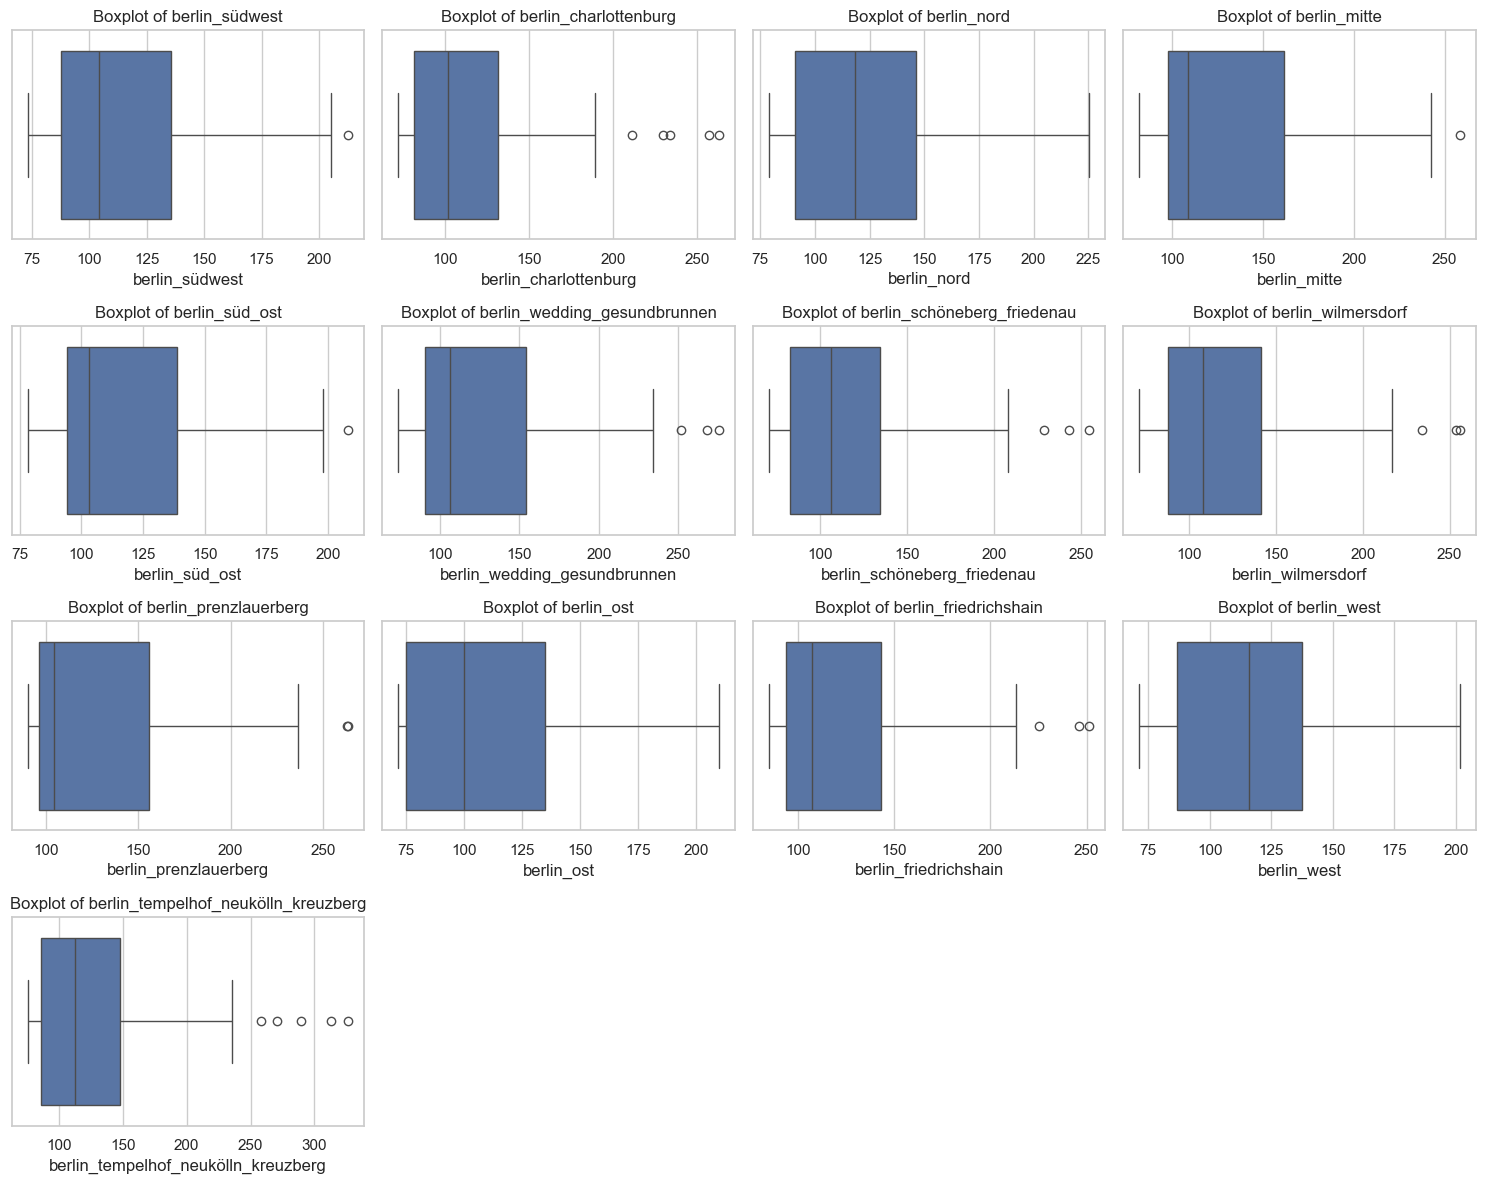

In [721]:
plt.figure(figsize=(15, 12))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x=data_greix[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

#### Über statistische Werte die Outlier von Berlin Charlottenburg entdecken

In [734]:
# Option: Z-Score Berechnung (95% Vertrauensintervall)
data_greix['z_score_berlin_charlottenburg'] = np.abs(stats.zscore(data_greix.berlin_charlottenburg))

# Identifizierung von Ausreißern mit einem Schwellenwert von 2
data_greix['outlier_z_score_berlin_charlottenburg'] = data_greix.z_score_berlin_charlottenburg> 2

# Anzeige der Datensätze mit Ausreißern
data_greix[data_greix['outlier_z_score_berlin_charlottenburg']]


,year,berlin_südwest,berlin_charlottenburg,berlin_nord,berlin_mitte,berlin_süd_ost,berlin_wedding_gesundbrunnen,berlin_schöneberg_friedenau,berlin_wilmersdorf,berlin_prenzlauerberg,berlin_ost,berlin_friedrichshain,berlin_west,berlin_tempelhof_neukölln_kreuzberg,z_score_berlin_charlottenburg,outlier_z_score_berlin_charlottenburg
35,2019,178.51,229.40,179.18,220.59,163.23,234.19,208.07,216.71,229.80,171.65,213.44,169.74,270.49,2.056597,True
36,2020,186.80,233.73,205.47,232.96,178.51,251.67,228.35,233.92,236.46,186.19,225.52,189.46,289.37,2.138518,True
37,2021,205.17,256.81,216.01,242.41,198.07,268.22,242.82,255.96,262.78,207.35,246.29,199.56,312.83,2.575177,True
38,2022,212.78,262.87,225.44,258.47,208.26,275.50,254.68,253.55,263.76,209.91,251.49,201.55,326.73,2.689828,True


In [735]:
# Option: IQR Berechnung (99,3% Intervall Normalverteilung)
Q1 = data_greix.berlin_charlottenburg.quantile(0.25)
Q3 = data_greix.berlin_charlottenburg.quantile(0.75)
IQR = Q3 - Q1

data_greix['outlier_iqr_berlin_charlottenburg'] = ((data_greix['berlin_charlottenburg'] < (Q1 - 1.5 * IQR)) | (data_greix['berlin_charlottenburg'] > (Q3 + 1.5 * IQR)))
data_greix[data_greix['outlier_iqr_berlin_charlottenburg']]

,year,berlin_südwest,berlin_charlottenburg,berlin_nord,berlin_mitte,berlin_süd_ost,berlin_wedding_gesundbrunnen,berlin_schöneberg_friedenau,berlin_wilmersdorf,berlin_prenzlauerberg,berlin_ost,berlin_friedrichshain,berlin_west,berlin_tempelhof_neukölln_kreuzberg,z_score_berlin_charlottenburg,outlier_z_score_berlin_charlottenburg,outlier_iqr_berlin_charlottenburg
34,2018,159.51,211.42,164.52,206.57,155.78,216.31,197.29,194.31,203.86,155.79,198.39,139.68,258.21,1.716427,False,True
35,2019,178.51,229.40,179.18,220.59,163.23,234.19,208.07,216.71,229.80,171.65,213.44,169.74,270.49,2.056597,True,True
36,2020,186.80,233.73,205.47,232.96,178.51,251.67,228.35,233.92,236.46,186.19,225.52,189.46,289.37,2.138518,True,True
37,2021,205.17,256.81,216.01,242.41,198.07,268.22,242.82,255.96,262.78,207.35,246.29,199.56,312.83,2.575177,True,True
38,2022,212.78,262.87,225.44,258.47,208.26,275.50,254.68,253.55,263.76,209.91,251.49,201.55,326.73,2.689828,True,True


Die Outlier befinden sich nur in den letzten Jahre von 2018 bis 2022, was Sinn macht, da die Wohnungspreise sehr schnell gestiegen sind, im Vergleich zu der Zeitspanne davor. Wir werden die Outlier aber in jedem Falle beibehalten, da sie ja keine Datenerfassungsfehler darstellen und wichtig für die weitere Analyse sind.

In [736]:
columns_to_drop = ['z_score_berlin_charlottenburg', 'outlier_z_score_berlin_charlottenburg', 'outlier_iqr_berlin_charlottenburg']
data_greix.drop(columns=columns_to_drop, inplace=True)

### Zeitreihendiagramme für die einzelnen Bezirke

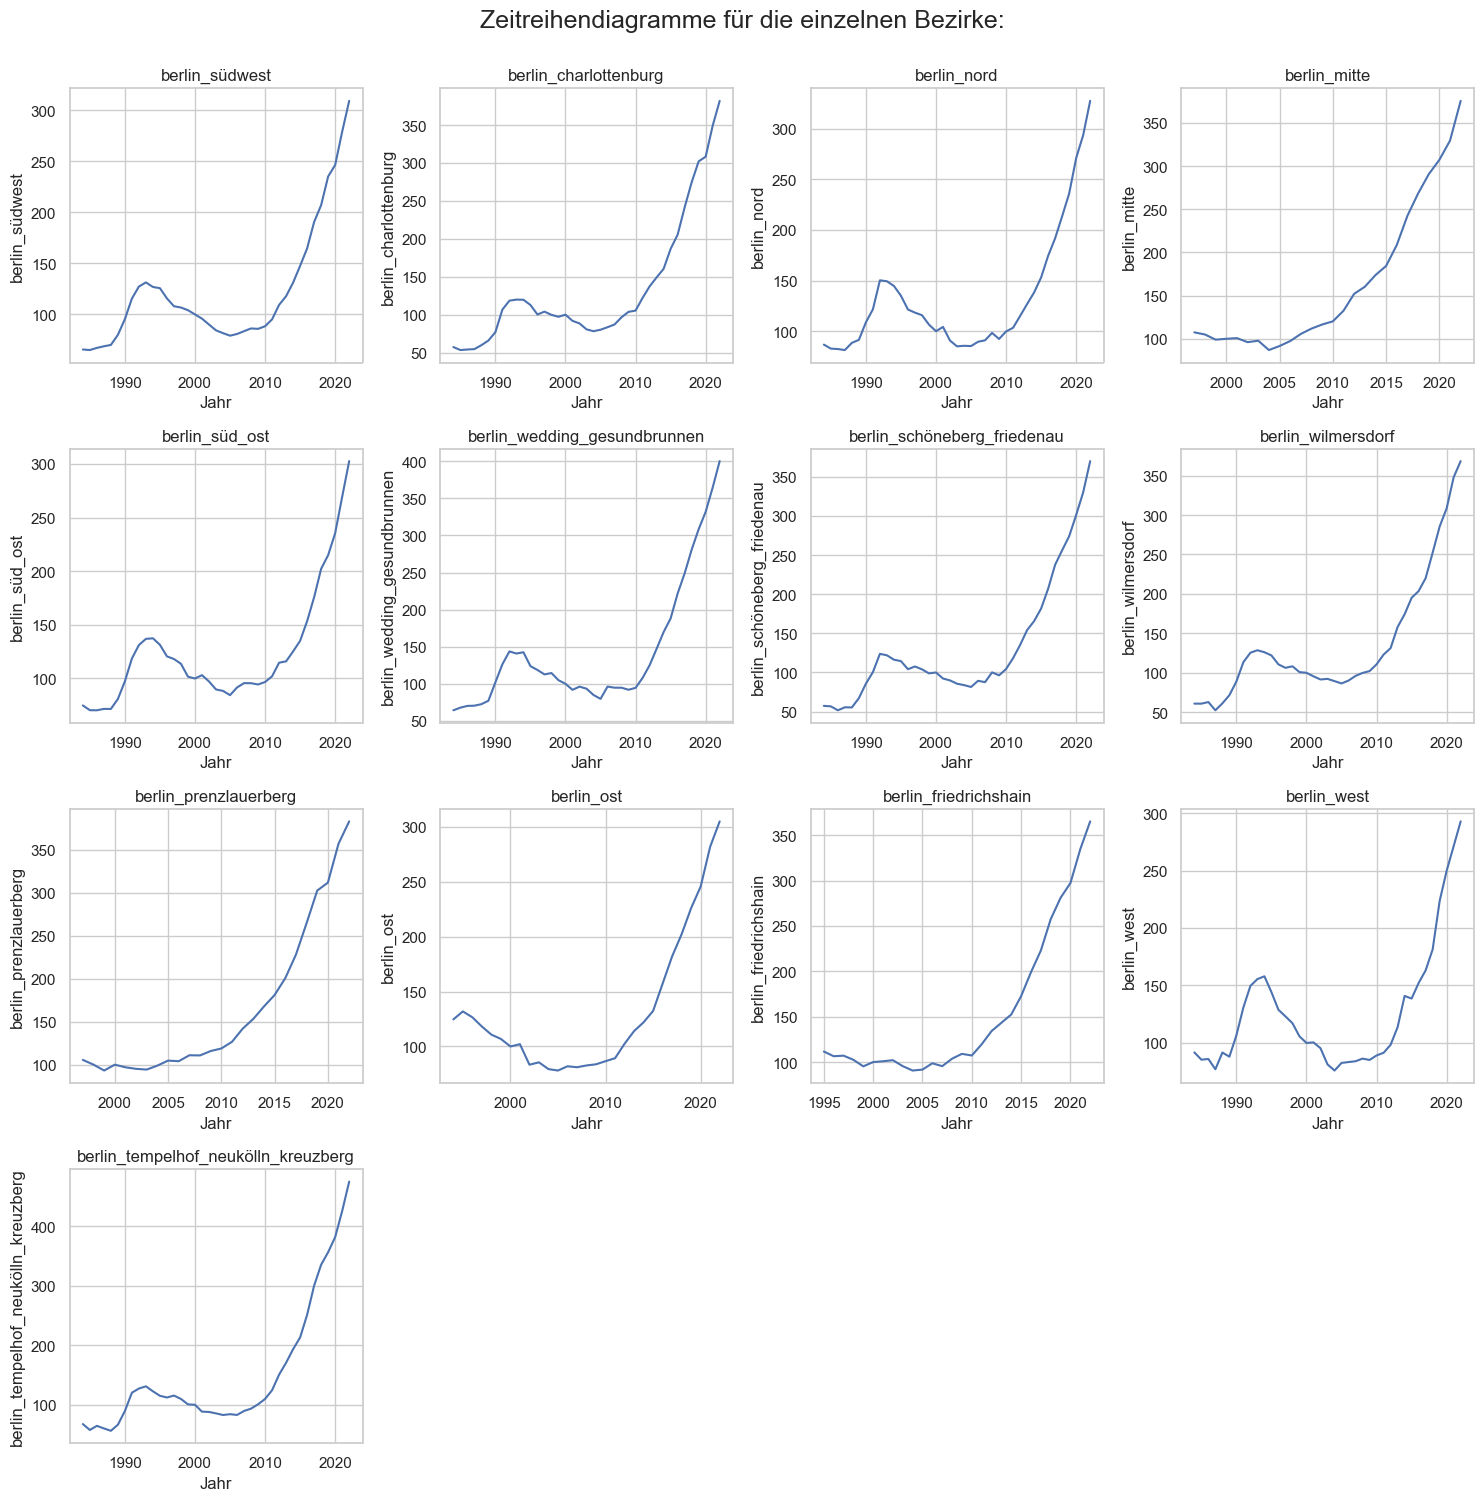

In [609]:
# Anzahl der Subplots pro Zeile und pro Spalte
subplots_per_row = 4

# Anzahl der benötigten Zeilen
num_rows = math.ceil(len(data_greix.columns[1:]) / subplots_per_row)

# Anzahl der Subplots in der letzten Zeile
subplots_last_row = len(data_greix.columns[1:]) % subplots_per_row

# Erstellen der Subplots
fig, axes = plt.subplots(num_rows, subplots_per_row, figsize=(15, 15))

# Iteration durch alle numerischen Spalten
for idx, column in enumerate(data_greix.columns[1:]):
    row_idx = idx // subplots_per_row
    col_idx = idx % subplots_per_row

    # Zeichnen des Zeitreihendiagramms für jede Spalte
    axes[row_idx, col_idx].plot(data_greix['year'], data_greix[column])
    axes[row_idx, col_idx].set_title(f'{column}')
    axes[row_idx, col_idx].set_xlabel('Jahr')
    axes[row_idx, col_idx].set_ylabel(column)

# Entfernen der überflüssigen Subplots in der letzten Zeile
for col_idx in range(subplots_last_row, subplots_per_row):
    fig.delaxes(axes[num_rows-1, col_idx])

plt.suptitle('Zeitreihendiagramme für die einzelnen Bezirke:', fontsize=18, y=1)

# Layout optimieren
plt.tight_layout()
plt.show()

### Vorbereitung des GREIX Datensatzes für die Datenintegration
Als Vorbereitung für die Datenintegration mit den anderen Datensätzen, müssen die GREIX Daten in eine Form gebracht werden, die es ermöglicht nachher einen merge durchzuführen. Das heißt wir nehmen eine Dimension raus, so dass die Bezirke alle in einer Spalte stehen.

In [751]:
# Laden des GREIX-Datensatzes
greix_path = 'data_greix_standardized_noNaN.xlsx'
greix_data = pd.read_excel(greix_path)

# Umbenennen der Spalte 'year' in 'Jahr'
greix_data.rename(columns={'year': 'Jahr'}, inplace=True)

# Umstrukturierung des GREIX-Datensatzes mit der 'melt'-Funktion
greix_melted = greix_data.melt(id_vars='Jahr', var_name='Bezirk', value_name='Immobilienpreisindex')
greix_melted_sorted = greix_melted.sort_values(by='Jahr')

# Entfernen des automatisch hinzugefügten Index
greix_melted_sorted.reset_index(drop=True, inplace=True)

greix_melted_sorted.to_excel('data_greix_readyMerge.xlsx')
greix_melted_sorted.head(20)

,Jahr,Bezirk,Immobilienpreisindex
0,1984,berlin_friedrichshain,88.72
1,1984,berlin_wedding_gesundbrunnen,89.23
2,1984,berlin_charlottenburg,79.54
3,1984,berlin_mitte,92.97
4,1984,berlin_schöneberg_friedenau,79.58
5,1984,berlin_prenzlauerberg,92.96
6,1984,berlin_nord,120.38
7,1984,berlin_west,127.35
8,1984,berlin_südwest,91.13
9,1984,berlin_ost,79.31


## Geburtenraten von ganz Berlin (1991-2022) und nach Bezirken (2005-2013):
Demografische Einflüsse: Die Geburtenrate könnte einen Einfluss auf die Nachfrage nach Wohnraum in einem Bezirk haben. Ein steigendes Geburtenniveau könnte auf eine steigende Bevölkerungszahl und damit auf eine höhere Nachfrage nach Wohnraum hindeuten.
Daher betrachten wir einen Datensatz der Geburtenraten in Berlin vom Amt für Statistik Berlin-Brandenburg, ergänzt mit Daten von Statista.

In [267]:
dataset_geburten = pd.read_excel('data_birth_original_1991-2022.xlsx')
dataset_geburten.head(15)

,Jahre,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01 Mitte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4123.0,-,-,-,-,NaN,NaN,NaN,NaN,NaN
2,02 Friedrichshain-Kreuzberg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3339.0,-,-,-,-,NaN,NaN,NaN,NaN,NaN
3,03 Pankow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4496.0,-,-,-,-,NaN,NaN,NaN,NaN,NaN
4,04 Charlottenburg-Wilmersdorf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2497.0,-,-,-,-,NaN,NaN,NaN,NaN,NaN
5,05 Spandau,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1998.0,-,-,-,-,NaN,NaN,NaN,NaN,NaN
6,06 Steglitz-Zehlendorf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2332.0,-,-,-,-,NaN,NaN,NaN,NaN,NaN
7,07 Tempelhof-Schöneberg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2968.0,-,-,-,-,NaN,NaN,NaN,NaN,NaN
8,08 Neukölln,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3554.0,-,-,-,-,NaN,NaN,NaN,NaN,NaN
9,09 Treptow-Köpenick,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2336.0,-,-,-,-,NaN,NaN,NaN,NaN,NaN


In [268]:
dataset_geburten.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Jahre   14 non-null     object 
 1   1991    1 non-null      float64
 2   1992    1 non-null      float64
 3   1993    1 non-null      float64
 4   1994    1 non-null      float64
 5   1995    1 non-null      float64
 6   1996    1 non-null      float64
 7   1997    1 non-null      float64
 8   1998    1 non-null      float64
 9   1999    1 non-null      float64
 10  2000    1 non-null      float64
 11  2001    1 non-null      float64
 12  2002    1 non-null      float64
 13  2003    1 non-null      float64
 14  2004    1 non-null      float64
 15  2005    13 non-null     float64
 16  2006    13 non-null     float64
 17  2007    13 non-null     float64
 18  2008    13 non-null     float64
 19  2009    13 non-null     float64
 20  2010    13 non-null     float64
 21  2011    13 non-null     float64
 22  2012

### Nullwerte betrachten

In [269]:
dataset_geburten.isna().sum()

Jahre     0
1991     13
1992     13
1993     13
1994     13
1995     13
1996     13
1997     13
1998     13
1999     13
2000     13
2001     13
2002     13
2003     13
2004     13
2005      1
2006      1
2007      1
2008      1
2009      1
2010      1
2011      1
2012      1
2013      1
2014      1
2015      1
2016      1
2017      1
2018     13
2019     13
2020     13
2021     13
2022     13
dtype: int64

Wir haben sehr viele Nullwerte, was bedeutet, dass wir uns definitiv etwas überlegen müssen um mit diesen Daten weiterzuarbeiten. 

### Umstrukturierung der Geburtendaten 
Wir vertauschen die Zeilen und Spalten für eine bessere Analyse.

In [335]:
dataset_geb = dataset_geburten.transpose()
dataset_geb.columns = dataset_geb.iloc[0]
dataset_geb = dataset_geb[1:]

dataset_geb.head(20)

Jahre,Region,01 Mitte,02 Friedrichshain-Kreuzberg,03 Pankow,04 Charlottenburg-Wilmersdorf,05 Spandau,06 Steglitz-Zehlendorf,07 Tempelhof-Schöneberg,08 Neukölln,09 Treptow-Köpenick,10 Marzahn-Hellersdorf,11 Lichtenberg,12 Reinickendorf,Berlin
1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30562.0
1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29667.0
1993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28724.0
1994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28503.0
1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28648.0
1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29905.0
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30369.0
1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29612.0
1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29856.0
2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29695.0


### Umbenennung und Zusammenführen der Bezirke
Die Bezirke des GREIX Datensatzes heißen nicht deckungsgleich mit den Bezirken des statistischen Informationssystems Berlin-Brandenburg, einige Bezirke heißen einfach nur etwas anders, aber ein paar der Gegenden sind nicht deckungsgleich und müssen daher zusammengelegt oder gesplittet  werden für die weitere Analyse.

In [336]:
def safe_divide_by_two(value):
    try:
        # Versuchen, den Wert in einen Integer umzuwandeln und dann zu teilen
        return int(value) // 2
    except ValueError:
        # Wenn der Wert nicht in einen Integer umgewandelt werden kann, wird er unverändert zurückgegeben
        return value

# Anwenden der Funktion auf die Spalten in denen die Werte aufgesplittet werden
dataset_geb['berlin_charlottenburg'] = dataset_geb['04  Charlottenburg-Wilmersdorf'].apply(safe_divide_by_two)
dataset_geb['berlin_wilmersdorf'] = dataset_geb['04  Charlottenburg-Wilmersdorf'].apply(safe_divide_by_two)

In [337]:
dataset_geb = dataset_geb.rename(columns={'01  Mitte': 'berlin_mitte'})
dataset_geb = dataset_geb.rename(columns={'02  Friedrichshain-Kreuzberg': 'berlin_friedrichshain'})
dataset_geb = dataset_geb.rename(columns={'05  Spandau': 'berlin_west'})
dataset_geb = dataset_geb.rename(columns={'06  Steglitz-Zehlendorf': 'berlin_südwest'})
dataset_geb = dataset_geb.rename(columns={'07  Tempelhof-Schöneberg': 'berlin_tempelhof_neukölln_kreuzberg'})
dataset_geb = dataset_geb.rename(columns={'Berlin': 'berlin'})

dataset_geb['berlin_nord'] = dataset_geb['12 Reinickendorf'] + dataset_geb['03  Pankow']
dataset_geb['berlin_süd_ost'] = dataset_geb['08  Neukölln'] + dataset_geb['09  Treptow-Köpenick']
dataset_geb['berlin_ost'] = dataset_geb['10 Marzahn-Hellersdorf'] + dataset_geb['11 Lichtenberg']

dataset_geb = dataset_geb.drop('03  Pankow', axis=1)
dataset_geb = dataset_geb.drop('04  Charlottenburg-Wilmersdorf', axis=1)
dataset_geb = dataset_geb.drop('08  Neukölln', axis=1)
dataset_geb = dataset_geb.drop('09  Treptow-Köpenick', axis=1)
dataset_geb = dataset_geb.drop('10 Marzahn-Hellersdorf', axis=1)
dataset_geb = dataset_geb.drop('11 Lichtenberg', axis=1)
dataset_geb = dataset_geb.drop('12 Reinickendorf', axis=1)
dataset_geb = dataset_geb.drop('Region', axis=1)

dataset_geb.to_excel('data_birth_standardized.xlsx')
dataset_geb.head(20)

Jahre,berlin_mitte,berlin_friedrichshain,berlin_west,berlin_südwest,berlin_tempelhof_neukölln_kreuzberg,berlin,berlin_charlottenburg,berlin_wilmersdorf,berlin_nord,berlin_süd_ost,berlin_ost
1991,NaN,NaN,NaN,NaN,NaN,30562.0,NaN,NaN,NaN,NaN,NaN
1992,NaN,NaN,NaN,NaN,NaN,29667.0,NaN,NaN,NaN,NaN,NaN
1993,NaN,NaN,NaN,NaN,NaN,28724.0,NaN,NaN,NaN,NaN,NaN
1994,NaN,NaN,NaN,NaN,NaN,28503.0,NaN,NaN,NaN,NaN,NaN
1995,NaN,NaN,NaN,NaN,NaN,28648.0,NaN,NaN,NaN,NaN,NaN
1996,NaN,NaN,NaN,NaN,NaN,29905.0,NaN,NaN,NaN,NaN,NaN
1997,NaN,NaN,NaN,NaN,NaN,30369.0,NaN,NaN,NaN,NaN,NaN
1998,NaN,NaN,NaN,NaN,NaN,29612.0,NaN,NaN,NaN,NaN,NaN
1999,NaN,NaN,NaN,NaN,NaN,29856.0,NaN,NaN,NaN,NaN,NaN
2000,NaN,NaN,NaN,NaN,NaN,29695.0,NaN,NaN,NaN,NaN,NaN


### Entwicklung der Gesamtgeburten über die Jahre
Um zu entscheiden, ob eine lineare Regression für die Schätzung der fehlenden Werte von 1984 bis 1990 geeignet ist wird hier die allgemeine Tendenz der Datenpunkte betrachtet.

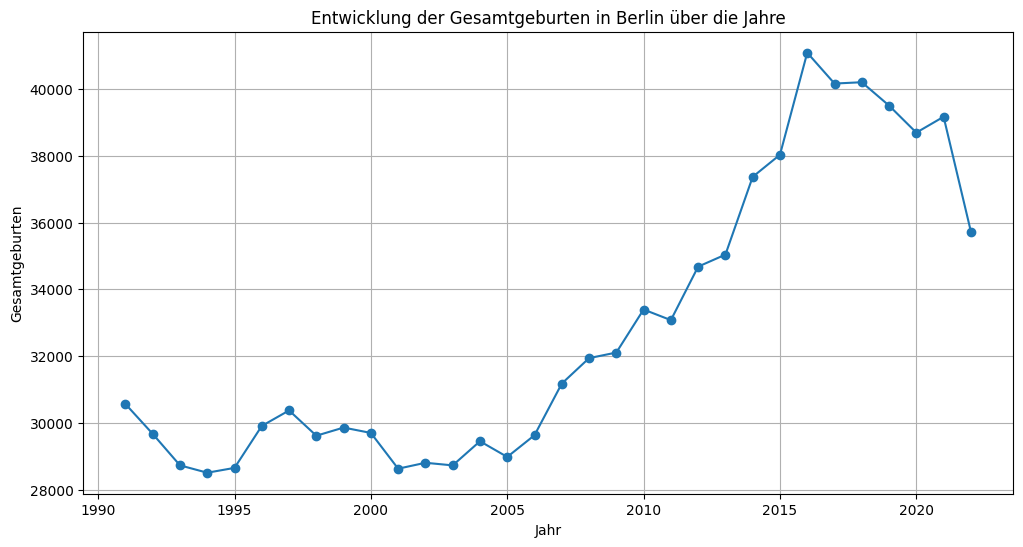

In [338]:
years = dataset_geb.index
total_births = dataset_geb['berlin']

# Erstellen eines Diagramms
plt.figure(figsize=(12, 6))
plt.plot(years, total_births, marker='o')
plt.title('Entwicklung der Gesamtgeburten in Berlin über die Jahre')
plt.xlabel('Jahr')
plt.ylabel('Gesamtgeburten')
plt.grid(True)
plt.show()


### Imputation von Nullwerten in Bezirksspalten durch Prozentsätze und lineare Regression
Wir berechnen die Prozentsätze der Geburten in den einzelnen Bezirken im Verhältnis zur Gesamtzahl der Geburten in Berlin. Anschließend werden die durchschnittlichen Prozentsätze jedes Bezirkes errechnet, basierend auf diesen werden dann die fehlenden Werte in den Bezirksspalten ergänzt. Zum Ende berechnen wir noch die Werte von 1984 bis 1990 durch lineare Regression.

In [340]:
# Lade die Daten
file_path = 'data_birth_standardized.xlsx'
data_birth = pd.read_excel(file_path)

# Konvertiere alle Spalten in numerische Werte, um Berechnungen durchführen zu können
# (außer die erste Spalte, die das Jahr darstellt)
for column in data_birth.columns[1:]:
    data_birth[column] = pd.to_numeric(data_birth[column], errors='coerce')

# Die Gesamtzahl der Geburten befindet sich in der Spalte "Berlin"
total_births_column = 'berlin'

# Erstelle eine Liste aller Bezirksspalten, die für die Berechnung verwendet werden sollen
# (Alle Spalten außer der ersten (Jahre) und der "Berlin"-Spalte)
bezirk_columns = [col for col in data_birth.columns if col not in ['Unnamed: 0', total_births_column]]

# Berechne die Prozentsätze für jedes Jahr, in dem Daten vorhanden sind
percentage_data = data_birth.copy()
for column in bezirk_columns:
    percentage_data[column] = data_birth[column] / data_birth[total_births_column] * 100

# Berechne die durchschnittlichen Prozentsätze für jeden Bezirk
average_percentage = percentage_data.mean()

# Ergänze die fehlenden Werte in den Bezirken basierend auf den durchschnittlichen Prozentsätzen
estimated_data = data_birth.copy()
for column in bezirk_columns:
    estimated_data[column] = estimated_data[column].fillna(estimated_data[total_births_column] * average_percentage[column] / 100)
    estimated_data[column] = estimated_data[column].round(0)  # Runde auf ganze Zahlen

# Anzeige der geschätzten Daten
estimated_data.head(20)

,Unnamed: 0,berlin_mitte,berlin_friedrichshain,berlin_west,berlin_südwest,berlin_tempelhof_neukölln_kreuzberg,berlin,berlin_charlottenburg,berlin_wilmersdorf,berlin_nord,berlin_süd_ost,berlin_ost
0,1991,3611.0,3019.0,1791.0,2014.0,2638.0,30562,1143.0,1143.0,5786.0,4990.0,4428.0
1,1992,3505.0,2930.0,1738.0,1955.0,2561.0,29667,1109.0,1109.0,5616.0,4844.0,4299.0
2,1993,3394.0,2837.0,1683.0,1893.0,2479.0,28724,1074.0,1074.0,5438.0,4690.0,4162.0
3,1994,3368.0,2815.0,1670.0,1879.0,2460.0,28503,1066.0,1066.0,5396.0,4654.0,4130.0
4,1995,3385.0,2830.0,1679.0,1888.0,2473.0,28648,1071.0,1071.0,5423.0,4677.0,4151.0
5,1996,3533.0,2954.0,1752.0,1971.0,2581.0,29905,1118.0,1118.0,5661.0,4883.0,4333.0
6,1997,3588.0,3000.0,1779.0,2002.0,2621.0,30369,1136.0,1136.0,5749.0,4958.0,4400.0
7,1998,3499.0,2925.0,1735.0,1952.0,2556.0,29612,1107.0,1107.0,5606.0,4835.0,4291.0
8,1999,3528.0,2949.0,1749.0,1968.0,2577.0,29856,1116.0,1116.0,5652.0,4875.0,4326.0
9,2000,3509.0,2933.0,1740.0,1957.0,2563.0,29695,1110.0,1110.0,5621.0,4848.0,4303.0


#### Berechnung der Werte von 1984 bis 1990 durch lineare Regression

In [341]:
# Konvertiere alle Spalten in numerische Werte
for column in estimated_data.columns[1:]:
    estimated_data[column] = pd.to_numeric(estimated_data[column], errors='coerce')

# Berechnung der linearen Regression und Vorhersagen für 1984-1990
years_to_predict = np.arange(1984, 1991).reshape(-1, 1) 
predicted_values = pd.DataFrame(years_to_predict, columns=['Unnamed: 0'])

for column in estimated_data.columns[1:]:  
    # Daten für die Regression vorbereiten (Jahre und Werte)
    valid_data = estimated_data[['Unnamed: 0', column]].dropna()
    X = valid_data[['Unnamed: 0']]
    y = valid_data[column]

    # Lineare Regression durchführen
    model = LinearRegression()
    model.fit(X, y)

    # Vorhersagen für die fehlenden Jahre hinzufügen
    predicted_values[column] = model.predict(predicted_values[['Unnamed: 0']]).round(0)  # Runde auf ganze Zahlen

# Füge die vorhergesagten Werte zur ursprünglichen Tabelle hinzu
extended_data = pd.concat([predicted_values, estimated_data], ignore_index=True).sort_values(by='Unnamed: 0').reset_index(drop=True)

# Speichern der erweiterten Tabelle in einer neuen Excel-Datei
extended_data.to_excel('data_birth_extended.xlsx', index=False)

# Anzeige der erweiterten Tabelle
extended_data.head(20)  

,Unnamed: 0,berlin_mitte,berlin_friedrichshain,berlin_west,berlin_südwest,berlin_tempelhof_neukölln_kreuzberg,berlin,berlin_charlottenburg,berlin_wilmersdorf,berlin_nord,berlin_süd_ost,berlin_ost
0,1984,2842.0,2378.0,1404.0,1584.0,2085.0,23974.0,903.0,903.0,4536.0,3896.0,3443.0
1,1985,2888.0,2417.0,1427.0,1610.0,2118.0,24368.0,918.0,918.0,4611.0,3961.0,3501.0
2,1986,2934.0,2455.0,1450.0,1636.0,2151.0,24763.0,932.0,932.0,4685.0,4026.0,3560.0
3,1987,2980.0,2494.0,1474.0,1661.0,2184.0,25157.0,946.0,946.0,4760.0,4092.0,3619.0
4,1988,3027.0,2532.0,1497.0,1687.0,2218.0,25551.0,961.0,961.0,4835.0,4157.0,3677.0
5,1989,3073.0,2571.0,1520.0,1713.0,2251.0,25946.0,975.0,975.0,4910.0,4222.0,3736.0
6,1990,3119.0,2609.0,1543.0,1739.0,2284.0,26340.0,990.0,990.0,4985.0,4288.0,3795.0
7,1991,3611.0,3019.0,1791.0,2014.0,2638.0,30562.0,1143.0,1143.0,5786.0,4990.0,4428.0
8,1992,3505.0,2930.0,1738.0,1955.0,2561.0,29667.0,1109.0,1109.0,5616.0,4844.0,4299.0
9,1993,3394.0,2837.0,1683.0,1893.0,2479.0,28724.0,1074.0,1074.0,5438.0,4690.0,4162.0


### Vorbereitung des Geburten Datensatzes für die Datenintegration
Jetzt haben wir alle Daten imputiert, so dass wir fortfahren und nun unseren Datensatz so vorbereiten können, dass es uns möglich ist die Daten später mit den anderen Datensätzen zu integrieren.

In [204]:
# Laden des angepassten Geburtsdatensatzes
birthdata_path = 'data_birth_extended.xlsx'
birthdata = pd.read_excel(birthdata_path)

# 'Jahr' Spalte Benennung nötig
birthdata.columns = ['Jahr'] + birthdata.columns[1:].tolist()

# 'berlin' Spalte loswerden, da wir uns auf die Bezirke konzentrieren
birthdata = birthdata.drop('berlin', axis=1)

# melt Funktion, um das Dataset umzuformen
birthdata_reshaped = pd.melt(birthdata, id_vars=['Jahr'], var_name='Bezirk', value_name='Geburtenrate')
birthdata_sorted = birthdata_reshaped.sort_values(by='Jahr')
birthdata_sorted.reset_index(drop=True, inplace=True)

birthdata_sorted.to_excel('data_birth_readyMerge.xlsx')
birthdata_sorted.head(10)

,Jahr,Bezirk,Geburtenrate
0,1984,berlin_wilmersdorf,903
1,1984,berlin_südwest,1584
2,1984,berlin_tempelhof_neukölln_kreuzberg,2085
3,1984,berlin_süd_ost,3896
4,1984,berlin_west,1404
5,1984,berlin_charlottenburg,903
6,1984,berlin_nord,4536
7,1984,berlin_ost,3443
8,1984,berlin_friedrichshain,2378
9,1984,berlin_mitte,2842


## Baufertigstellungen nach Bezirken (2012 - 2020)
Wir betrachten die Baufertigstellungen in Berlin als wesentlichen Faktor für die Vorhersage des Immobilienpreisindex, da sie einen signifikanten Einfluss auf das Angebot an Wohnraum in der Stadt haben. Die Anzahl der fertiggestellten Bauten wirkt sich direkt auf das Gleichgewicht von Angebot und Nachfrage auf dem Immobilienmarkt aus. Ein Anstieg der Baufertigstellungen könnte bei gleichbleibender Nachfrage potenziell zu einer Senkung der Immobilienpreise beitragen. Umgekehrt kann ein Rückgang der Baufertigstellungen bei gleichbleibender oder steigender Nachfrage zu einem Angebotsmangel führen, was die Preise in die Höhe treiben könnte. Die Daten stammen vom Amt für Statistik Berlin-Brandenburg.

In [8]:
# Laden des Baufertigstellungsdatensatzes
baufertigstellungen_path = 'data_baufertigstellungen_original.xlsx'
baufertigstellungen = pd.read_excel(baufertigstellungen_path)

baufertigstellungen.head(10)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Baufertigstellungen (1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Region by Jahr and Summation Options,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Counting: Anzahl Baufertigstellungen, Anzahl W...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Jahr,NaN,2012,NaN,2013,NaN,2014,NaN,2015,NaN,2016,NaN,2017,NaN,2018,NaN,2019,NaN,2020,NaN
6,Summation Options,NaN,Anzahl Baufertigstellungen,Anzahl Wohnungen,Anzahl Baufertigstellungen,Anzahl Wohnungen,Anzahl Baufertigstellungen,Anzahl Wohnungen,Anzahl Baufertigstellungen,Anzahl Wohnungen,Anzahl Baufertigstellungen,Anzahl Wohnungen,Anzahl Baufertigstellungen,Anzahl Wohnungen,Anzahl Baufertigstellungen,Anzahl Wohnungen,Anzahl Baufertigstellungen,Anzahl Wohnungen,Anzahl Baufertigstellungen,Anzahl Wohnungen
7,NaN,Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,Berlin,3151,5417,3266,6641,3356,8744,3370,10722,3570,13659,3228,15669,3418,16706,3388,18999,2556,16337
9,NaN,01 Mitte,79,378,146,1158,132,1278,120,998,150,2182,192,2510,198,2406,234,3918,156,1786


### Bereinigung des Datensatzes 
Um den Datensatz sinnvoll nützen zu können, ist es nötig die Daten zu bereinigen. Wir haben hier sehr viele überflüssige Zeilen, und wollen auch nur die Baufertigstellungen betrachten, daher können wir die Spalte mit der Anzahl der Wohnungen auch los werden.

In [112]:
baufertigstellungen = pd.read_excel(baufertigstellungen_path, skiprows=7)

# Behalten nur der relevanten Spalten
relevant_columns_index = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18]
baufertigstellungen_cleaned = baufertigstellungen.iloc[:, relevant_columns_index]

# Umbenennen der Spalten, um die Jahre einzuschließen
baufertigstellungen_cleaned.columns = ['Bezirk'] + [str(year) for year in range(2012, 2021)]

# Entfernen aller Zeilen mit NaN-Werten 
baufertigstellungen_cleaned = baufertigstellungen_cleaned.dropna()

# Zurücksetzen des Index
baufertigstellungen_cleaned = baufertigstellungen_cleaned.reset_index(drop=True)

# Anzeigen des bereinigten Datensatzes
baufertigstellungen_cleaned.head(40)


,Bezirk,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Berlin,3151.0,3266.0,3356.0,3370.0,3570.0,3228.0,3418.0,3388.0,2556.0
1,01 Mitte,79.0,146.0,132.0,120.0,150.0,192.0,198.0,234.0,156.0
2,02 Friedrichshain-Kreuzberg,79.0,91.0,99.0,154.0,129.0,156.0,203.0,134.0,109.0
3,03 Pankow,602.0,499.0,546.0,581.0,506.0,440.0,387.0,480.0,399.0
4,04 Charlottenburg-Wilmersdorf,104.0,142.0,217.0,146.0,124.0,168.0,191.0,139.0,128.0
5,05 Spandau,369.0,335.0,240.0,238.0,209.0,192.0,245.0,273.0,240.0
6,06 Steglitz-Zehlendorf,276.0,528.0,367.0,313.0,464.0,252.0,229.0,197.0,172.0
7,07 Tempelhof-Schöneberg,156.0,89.0,148.0,142.0,169.0,126.0,200.0,251.0,105.0
8,08 Neukölln,111.0,153.0,207.0,167.0,158.0,171.0,306.0,189.0,99.0
9,09 Treptow-Köpenick,361.0,303.0,389.0,446.0,503.0,469.0,601.0,530.0,381.0


In [113]:
build_structured = baufertigstellungen_cleaned.transpose()
build_structured.columns = build_structured.iloc[0]
build_structured = build_structured[1:]

build_structured.head(30)

Bezirk,Berlin,01 Mitte,02 Friedrichshain-Kreuzberg,03 Pankow,04 Charlottenburg-Wilmersdorf,05 Spandau,06 Steglitz-Zehlendorf,07 Tempelhof-Schöneberg,08 Neukölln,09 Treptow-Köpenick,10 Marzahn-Hellersdorf,11 Lichtenberg,12 Reinickendorf
2012,3151.0,79.0,79.0,602.0,104.0,369.0,276.0,156.0,111.0,361.0,424.0,341.0,249.0
2013,3266.0,146.0,91.0,499.0,142.0,335.0,528.0,89.0,153.0,303.0,345.0,360.0,275.0
2014,3356.0,132.0,99.0,546.0,217.0,240.0,367.0,148.0,207.0,389.0,435.0,367.0,209.0
2015,3370.0,120.0,154.0,581.0,146.0,238.0,313.0,142.0,167.0,446.0,461.0,355.0,247.0
2016,3570.0,150.0,129.0,506.0,124.0,209.0,464.0,169.0,158.0,503.0,486.0,427.0,245.0
2017,3228.0,192.0,156.0,440.0,168.0,192.0,252.0,126.0,171.0,469.0,449.0,409.0,204.0
2018,3418.0,198.0,203.0,387.0,191.0,245.0,229.0,200.0,306.0,601.0,384.0,230.0,244.0
2019,3388.0,234.0,134.0,480.0,139.0,273.0,197.0,251.0,189.0,530.0,453.0,304.0,204.0
2020,2556.0,156.0,109.0,399.0,128.0,240.0,172.0,105.0,99.0,381.0,374.0,195.0,198.0


### Umbenennung und Zusammenführen der Bezirke
Auch hier heißen die Bezirke des Baufertigstellungsdatensatzes nicht deckungsgleich mit den Bezirken des GREIX Datensatzes. Wir benennen sie also um, und legen einige Bezirke zusammen.

In [114]:
build_structured = build_structured.rename(columns={'01 Mitte': 'berlin_mitte'})
build_structured = build_structured.rename(columns={'02  Friedrichshain-Kreuzberg': 'berlin_friedrichshain'})
build_structured = build_structured.rename(columns={'05  Spandau': 'berlin_west'})
build_structured = build_structured.rename(columns={'06  Steglitz-Zehlendorf': 'berlin_südwest'})
build_structured = build_structured.rename(columns={'07  Tempelhof-Schöneberg': 'berlin_tempelhof_neukölln_kreuzberg'})
build_structured = build_structured.rename(columns={'Berlin': 'berlin'})

build_structured['berlin_nord'] = build_structured['12 Reinickendorf'] + build_structured['03  Pankow']
build_structured['berlin_charlottenburg'] = build_structured['04  Charlottenburg-Wilmersdorf'] // 2
build_structured['berlin_wilmersdorf'] = build_structured['04  Charlottenburg-Wilmersdorf'] // 2
build_structured['berlin_süd_ost'] = build_structured['08  Neukölln'] + build_structured['09  Treptow-Köpenick']
build_structured['berlin_ost'] = build_structured['10 Marzahn-Hellersdorf'] + build_structured['11 Lichtenberg']

build_structured = build_structured.drop('03  Pankow', axis=1)
build_structured = build_structured.drop('04  Charlottenburg-Wilmersdorf', axis=1)
build_structured = build_structured.drop('08  Neukölln', axis=1)
build_structured = build_structured.drop('09  Treptow-Köpenick', axis=1)
build_structured = build_structured.drop('10 Marzahn-Hellersdorf', axis=1)
build_structured = build_structured.drop('11 Lichtenberg', axis=1)
build_structured = build_structured.drop('12 Reinickendorf', axis=1)

build_structured.to_excel('data_baufertigstellungen_standardized.xlsx')
build_structured.head(20)

Bezirk,berlin,berlin_mitte,berlin_friedrichshain,berlin_west,berlin_südwest,berlin_tempelhof_neukölln_kreuzberg,berlin_nord,berlin_charlottenburg,berlin_wilmersdorf,berlin_süd_ost,berlin_ost
2012,3151.0,79.0,79.0,369.0,276.0,156.0,851.0,52.0,52.0,472.0,765.0
2013,3266.0,146.0,91.0,335.0,528.0,89.0,774.0,71.0,71.0,456.0,705.0
2014,3356.0,132.0,99.0,240.0,367.0,148.0,755.0,108.0,108.0,596.0,802.0
2015,3370.0,120.0,154.0,238.0,313.0,142.0,828.0,73.0,73.0,613.0,816.0
2016,3570.0,150.0,129.0,209.0,464.0,169.0,751.0,62.0,62.0,661.0,913.0
2017,3228.0,192.0,156.0,192.0,252.0,126.0,644.0,84.0,84.0,640.0,858.0
2018,3418.0,198.0,203.0,245.0,229.0,200.0,631.0,95.0,95.0,907.0,614.0
2019,3388.0,234.0,134.0,273.0,197.0,251.0,684.0,69.0,69.0,719.0,757.0
2020,2556.0,156.0,109.0,240.0,172.0,105.0,597.0,64.0,64.0,480.0,569.0


### Vorbereitung des Baufertigstellungsdatensatzes für die Datenintegration

In [115]:
# Laden des angepassten Baufertigstellungsdatensatzes
data_path = 'data_baufertigstellungen_standardized.xlsx'
buildingdata = pd.read_excel(data_path)

# 'Jahr' Spalte Benennung nötig
buildingdata.columns = ['Jahr'] + buildingdata.columns[1:].tolist()

# melt Funktion, um das Dataset umzuformen
data_reshaped = pd.melt(buildingdata, id_vars=['Jahr'], var_name='Bezirk', value_name='Baufertigstellungen')
buildingdata_sorted = data_reshaped.sort_values(by='Jahr')
buildingdata_sorted.reset_index(drop=True, inplace=True)

buildingdata_sorted.to_excel('data_building_2012-2020_sorted.xlsx')
buildingdata_sorted.head(10)

,Jahr,Bezirk,Baufertigstellungen
0,2012,berlin,3151
1,2012,berlin_süd_ost,472
2,2012,berlin_ost,765
3,2012,berlin_friedrichshain,79
4,2012,berlin_charlottenburg,52
5,2012,berlin_wilmersdorf,52
6,2012,berlin_west,369
7,2012,berlin_nord,851
8,2012,berlin_südwest,276
9,2012,berlin_tempelhof_neukölln_kreuzberg,156


### Daten ergänzen
Da wir nur Daten für 9 Jahre haben, würde es sehr helfen, für soviele Jahre wie möglich, wenigstens die Daten für ganz Berlin zu ergänzen. Das Statistische Bundesamt hat Werte von 2008 bis 2022. Diese lassen wir uns anzeigen.

In [116]:
baufertigstellungen_allBerlin = pd.read_excel('data_baufertigstellungen_allBerlin.xlsx')
baufertigstellungen_allBerlin.head(20)

,Table 1,Unnamed: 1
0,Jahr,Baufertigstellungen
1,2008,2938
2,2009,2554
3,2010,2592
4,2011,2585
5,2012,3151
6,2013,3266
7,2014,3356
8,2015,3370
9,2016,3570


Die Daten müssen noch etwas umgewandelt werden bevor wir sie mit unserem bestehenden Datenset mergen können.

In [284]:
# Laden des Datensatzes, Überspringen der ursprünglichen Kopfzeile
data = pd.read_excel('data_baufertigstellungen_allBerlin.xlsx', skiprows=1)

# Hinzufügen der neuen Spalte 'Bezirk' mit dem Wert 'berlin' in allen Zeilen
data['Bezirk'] = 'berlin'

# Umbenennen der ersten beiden Spalten in 'Jahr' und 'Baufertigstellungen'
data.columns = ['Jahr', 'Baufertigstellungen'] + list(data.columns[2:])

data.to_excel('data_building_2008-2022.xlsx', index=False)

data.head(10)

,Jahr,Baufertigstellungen,Bezirk
0,2008,2938,berlin
1,2009,2554,berlin
2,2010,2592,berlin
3,2011,2585,berlin
4,2012,3151,berlin
5,2013,3266,berlin
6,2014,3356,berlin
7,2015,3370,berlin
8,2016,3570,berlin
9,2017,3228,berlin


#### Kombinieren der Extra Daten mit dem ursprünglichen Datensatz der Baufertigstellungen

In [118]:
# Laden der Datensätze
data_ready_merge = pd.read_excel('data_building_2012-2020_sorted.xlsx')
data_2008_2022 = pd.read_excel('data_building_2008-2022.xlsx')

# Entfernen der Duplikate für die Jahre 2012 bis 2020 für den Bezirk 'berlin' aus dem einen Datensatz
data_2008_2022_filtered = data_2008_2022[~((data_2008_2022['Jahr'] >= 2012) & 
                                               (data_2008_2022['Jahr'] <= 2020) & 
                                               (data_2008_2022['Bezirk'] == 'berlin'))]

# Kombinieren der beiden Datenmengen
combined_data = pd.concat([data_ready_merge, data_2008_2022_filtered])

# Sortieren des kombinierten DataFrames nach 'Jahr' und 'Bezirk'
combined_data = combined_data.sort_values(by=['Jahr', 'Bezirk'])

combined_data = combined_data.drop(columns=['Unnamed: 0'])
combined_data.reset_index(drop=True, inplace=True)
combined_data.to_excel('data_full_2008-2022.xlsx', index=False)

# Anzeigen der ersten paar Zeilen zur Überprüfung
combined_data.head(10)


,Jahr,Bezirk,Baufertigstellungen
0,2008,berlin,2938
1,2009,berlin,2554
2,2010,berlin,2592
3,2011,berlin,2585
4,2012,berlin,3151
5,2012,berlin_charlottenburg,52
6,2012,berlin_friedrichshain,79
7,2012,berlin_mitte,79
8,2012,berlin_nord,851
9,2012,berlin_ost,765


#### Werte für die einzelnen Bezirke imputieren
Jetzt fehlen uns für die Bezirke aber immer noch die Werte für die Jahre 2008, 2009, 2010, 2011, 2021, 2022.
Dafür betrachten wir die Verteilung der Baufertigstellungen aus anderen Jahren als Basis für die Verteilung in den spezifischen Jahren, wie oben bei den Geburtenraten.
Wir berechnen also die Prozentsätze der Baufertigstellungen in den einzelnen Bezirken im Verhältnis zur Gesamtzahl der Baufertigstellungen in Berlin. Anschließend werden die durchschnittlichen Prozentsätze jedes Bezirkes errechnet, basierend auf diesen werden dann die fehlenden Werte in den Bezirksspalten ergänzt.

In [285]:
# Laden des Datensatzes
data_path = 'data_full_2008-2022.xlsx'  
data_buildings = pd.read_excel(data_path)

# Identifizieren der Jahre, in denen nur Gesamtwerte für Berlin vorliegen
specific_years = [2008, 2009, 2010, 2011, 2021, 2022]

# Filtern des Datensatzes, um nur die Daten für Bezirke (ohne 'berlin' Gesamtwerte) in den anderen Jahren zu erhalten
bezirk_data = data_buildings[(~data_buildings['Jahr'].isin(specific_years)) & (data_buildings['Bezirk'] != 'berlin')]

# Berechnung der durchschnittlichen Anteile jedes Bezirks an den Gesamtfertigstellungen
bezirk_proportions = bezirk_data.groupby('Bezirk')['Baufertigstellungen'].sum() / bezirk_data['Baufertigstellungen'].sum()

# Berechnung der Baufertigstellungen für jeden Bezirk in den spezifischen Jahren
new_rows = []
for year in specific_years:
    total_for_year = data_buildings[(data_buildings['Jahr'] == year) & (data_buildings['Bezirk'] == 'berlin')]['Baufertigstellungen'].values[0]
    for bezirk, proportion in bezirk_proportions.items():
        estimated_value = round(total_for_year * proportion)
        new_rows.append({'Jahr': year, 'Bezirk': bezirk, 'Baufertigstellungen': estimated_value})

# Hinzufügen der neuen Zeilen zum DataFrame
new_rows_df = pd.DataFrame(new_rows)
data_buildings = pd.concat([data_buildings, new_rows_df], ignore_index=True)

# Entfernen der ursprünglichen 'berlin' Gesamtwerte 
data_buildings = data_buildings[~((data_buildings['Bezirk'] == 'berlin'))]

# Sortieren des DataFrames für eine bessere Ansicht
data_buildings = data_buildings.sort_values(by=['Jahr', 'Bezirk'])
data_buildings.reset_index(drop=True, inplace=True)

# Anzeigen der ersten paar Zeilen zur Überprüfung
data_buildings.head(10)

,Jahr,Bezirk,Baufertigstellungen
0,2008,berlin_charlottenburg,68
1,2008,berlin_friedrichshain,116
2,2008,berlin_mitte,141
3,2008,berlin_nord,653
4,2008,berlin_ost,682
5,2008,berlin_süd_ost,556
6,2008,berlin_südwest,281
7,2008,berlin_tempelhof_neukölln_kreuzberg,139
8,2008,berlin_west,235
9,2008,berlin_wilmersdorf,68


### Analyse der Entwicklungstrends bei Baufertigstellungen
Um die optimale Methode für die Ergänzung fehlender Daten zu bestimmen, ist es entscheidend, die Entwicklungstrends der Baufertigstellungen über die Jahre hinweg gründlich zu analysieren. Diese Betrachtung ermöglicht es uns, ein fundiertes Verständnis dafür zu entwickeln, wie sich die Baufertigstellungen in verschiedenen Bezirken verändert haben, und hilft uns, die am besten geeignete Technik für die Datenimputation zu wählen.

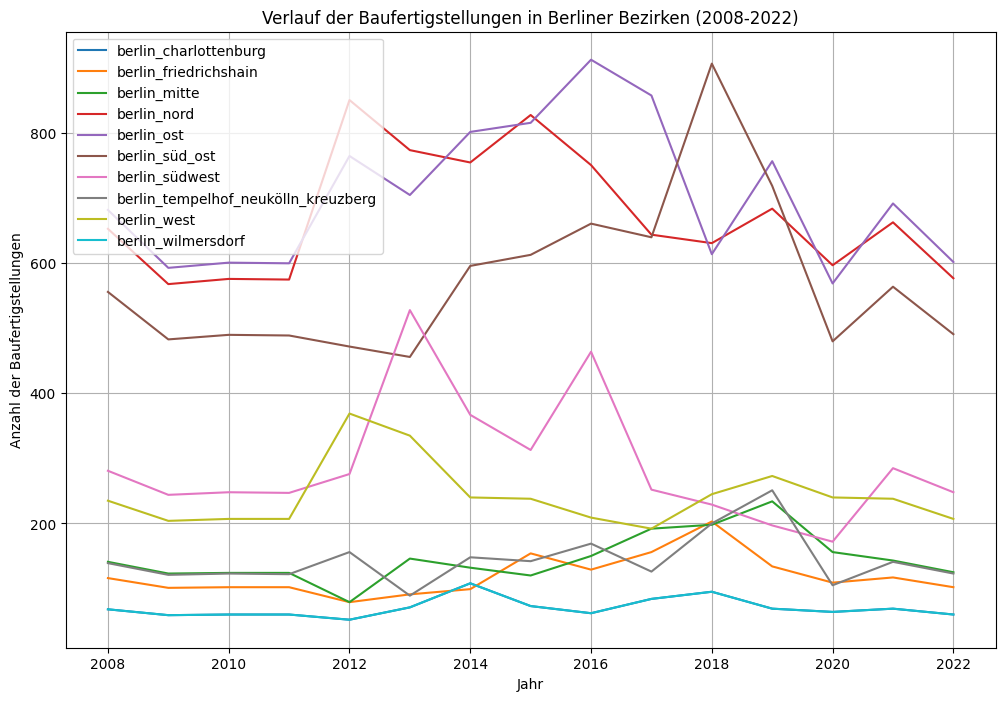

In [133]:
# Einzigartige Bezirke im Datensatz extrahieren
unique_districts = data_buildings['Bezirk'].unique()

# Erstellen eines Diagramms zur Visualisierung
plt.figure(figsize=(12, 8))

for district in unique_districts:
    # Filtern der Daten für den aktuellen Bezirk
    district_data = data_buildings[data_buildings['Bezirk'] == district]

    # Plotten der Daten für den aktuellen Bezirk
    plt.plot(district_data['Jahr'], district_data['Baufertigstellungen'], label=district)

# Hinzufügen von Titel und Beschriftungen
plt.title('Verlauf der Baufertigstellungen in Berliner Bezirken (2008-2022)')
plt.xlabel('Jahr')
plt.ylabel('Anzahl der Baufertigstellungen')
plt.legend(loc='upper left')
plt.grid(True)

# Anzeigen des Diagramms
plt.show()


Im Durchschnitt zeigen fast alle Bezirke einige Schwankungen in der Anzahl der Baufertigstellungen über die Jahre hinweg. Einige Bezirke bleiben aber auch relativ konstant. Basierend auf den verschiedenen Mustern könnte man verschiedene Methoden zur Ergänzung der Daten wählen. 
- Lineare oder polynomiale Interpolationstechniken
- Zeitreihenanalyse
- Splines (könnten für größere Schwankungen Sinn machen) 

Wir beschränken uns für die weitergehende Datenanalyse und das Training unseres ML-Modells auf den Median. Dieser bietet zwar keine optimale Lösung, ist aber schon mal weniger anfällig für Ausreißer als der Durchschnitt und auch besser geeignet für Bezirke mit größeren Schwankungen. 

In [283]:
# Berechnung des Medians der Baufertigstellungen für jeden Bezirk
median_values = data_buildings.groupby('Bezirk')['Baufertigstellungen'].median()

# Erstellen eines neuen Dataframes für die imputierten Werte
imputed_data = pd.DataFrame()

# Hinzufügen der imputierten Werte für jedes Jahr von 1984 bis 2007 für jeden Bezirk
for year in range(1984, 2008):
    for district, median in median_values.items():
        imputed_row = pd.DataFrame({'Jahr': [year], 'Bezirk': [district], 'Baufertigstellungen': [median]})
        imputed_data = pd.concat([imputed_data, imputed_row], ignore_index=True)

# Zusammenführen der ursprünglichen Daten mit den imputierten Daten
full_data = pd.concat([data_buildings, imputed_data])

# Sortieren der Daten nach Jahr und Zurücksetzen des Index
full_data_sorted = full_data.sort_values(by='Jahr').reset_index(drop=True)

# Speichern der vollständigen und sortierten Daten in einer neuen Datei
full_data_sorted.to_excel('data_building_readyMerge.xlsx', index=False)

full_data_sorted.head(15)

,Jahr,Bezirk,Baufertigstellungen
0,1984,berlin_friedrichshain,109.0
1,1984,berlin_charlottenburg,68.0
2,1984,berlin_nord,653.0
3,1984,berlin_mitte,141.0
4,1984,berlin_ost,692.0
5,1984,berlin_süd_ost,556.0
6,1984,berlin_west,238.0
7,1984,berlin_wilmersdorf,68.0
8,1984,berlin_tempelhof_neukölln_kreuzberg,139.0
9,1984,berlin_südwest,252.0


## Datenintegration 
Wir sind endlich soweit, dass wir alle drei Datensets zusammenführen können

In [289]:
# Laden der drei Datensätze
file_path_greix = 'data_greix_readyMerge.xlsx'  
file_path_birth = 'data_birth_readyMerge.xlsx'
file_path_building = 'data_building_readyMerge.xlsx'

data_greix = pd.read_excel(file_path_greix)
data_birth = pd.read_excel(file_path_birth)
data_building = pd.read_excel(file_path_building)

# Entfernen der unnötigen 'Unnamed: 0' Spalten, falls vorhanden
data_greix.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
data_birth.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
data_building.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

# Zusammenführen der Datensätze mit einem 'outer' Join
full_dataset = data_greix.merge(data_birth, on=['Jahr', 'Bezirk'], how='outer')
full_dataset = full_dataset.merge(data_building, on=['Jahr', 'Bezirk'], how='outer')

# Speichern des zusammengeführten Datensatzes als neue Excel-Datei
full_dataset.to_excel('dataset_merged.xlsx', index=False)

# Anzeigen des zusammengeführten Datensatzes
full_dataset.head(25)

,Jahr,Bezirk,Immobilienpreisindex,Geburtenrate,Baufertigstellungen
0,1984,berlin_friedrichshain,88.72,2378.0,109.0
1,1984,berlin_wedding_gesundbrunnen,89.23,NaN,NaN
2,1984,berlin_charlottenburg,79.54,903.0,68.0
3,1984,berlin_mitte,92.97,2842.0,141.0
4,1984,berlin_schöneberg_friedenau,79.58,NaN,NaN
5,1984,berlin_prenzlauerberg,92.96,NaN,NaN
6,1984,berlin_nord,120.38,4536.0,653.0
7,1984,berlin_west,127.35,1404.0,238.0
8,1984,berlin_südwest,91.13,1584.0,252.0
9,1984,berlin_ost,79.31,3443.0,692.0


## Untersuchung des neuen Datensatzes der alle Features enthält

In [288]:
# Statistische Beschreibung
data_description = full_dataset.describe()

# Nullwerte überprüfen
missing_values = full_dataset.isnull().sum()

# Ergebnisse ausgeben
print("Statistische Beschreibung des Datensets:")
print(data_description)
print("Fehlende Werte:")
print(missing_values)

Statistische Beschreibung des Datensets:
              Jahr  Immobilienpreisindex  Geburtenrate  Baufertigstellungen
count   507.000000            507.000000    390.000000           390.000000
mean   2003.000000            122.965740   3146.597436           296.233333
std      11.265744             47.960288   1673.165394           239.710106
min    1984.000000             63.820000    903.000000            52.000000
25%    1993.000000             88.525000   1716.000000           109.000000
50%    2003.000000            106.410000   2837.000000           201.500000
75%    2013.000000            140.220000   4331.250000           556.000000
max    2022.000000            326.730000   7778.000000           913.000000
Fehlende Werte:
Jahr                      0
Bezirk                    0
Immobilienpreisindex      0
Geburtenrate            117
Baufertigstellungen     117
dtype: int64


### Nullwerte behandeln
Es gibt drei Bezirke für die wir keine Daten der Geburtenraten oder Baufertigstellungen haben: Prenzlauer Berg, Berlin Wedding Gesundbrunnen, Berlin Schöneberg Friedenau. Für diese sehr spezifischen Bezirke des GREIX Datensets gab es vom Amt für Statistik Berlin-Brandenburg keine Daten, da sie nur Teilbezirke eines größeren Kiez darstellen. Wir entfernen diese also aus unserem Datensatz.

In [163]:
full_dataset = full_dataset.dropna()

# Nullwerte nochmal überprüfen
missing_values = full_dataset.isnull().sum()

full_dataset.to_excel('dataset_merged_cleaned.xlsx', index=False)
print(missing_values)

Jahr                    0
Bezirk                  0
Immobilienpreisindex    0
Geburtenrate            0
Baufertigstellungen     0
dtype: int64


### Korrelationsmatrix
Relevante Zusammenhänge visualisieren

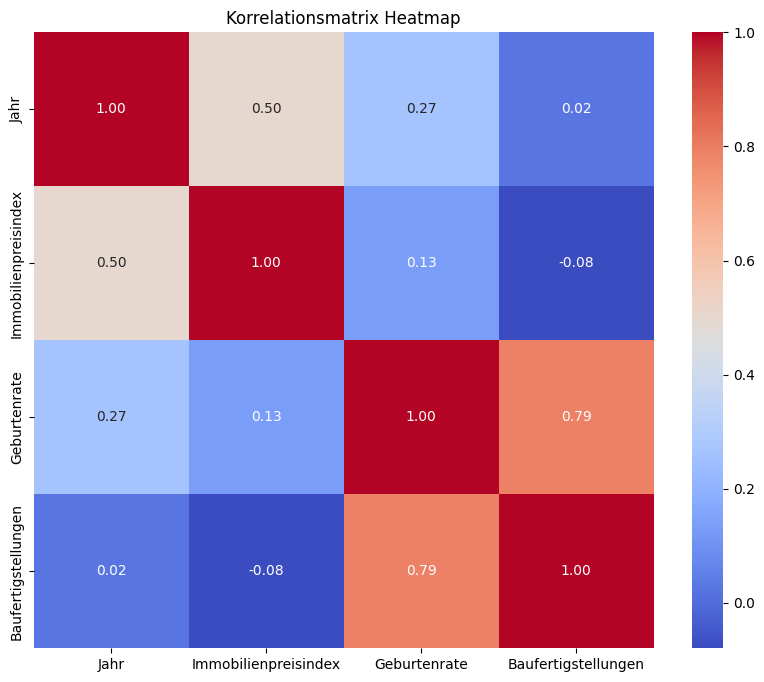

In [296]:
# Entfernen von nicht-numerischen Spalten aus dem Datensatz
numeric_data = full_dataset.select_dtypes(include=[np.number])

# Berechnung der Korrelationsmatrix für die numerischen Daten
correlation_matrix = numeric_data.corr()

# Visualisierung der Korrelationsmatrix mit einer Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korrelationsmatrix Heatmap")
plt.show()

### Trendanalyse des Immobilienpreisindex über die Jahre
Wir visualisieren zunächst den durchschnittlichen Immobilienpreisindex pro Jahr über alle Bezirke hinweg, um allgemeine Trends in den Immobilienpreisen zu veranschaulichen.

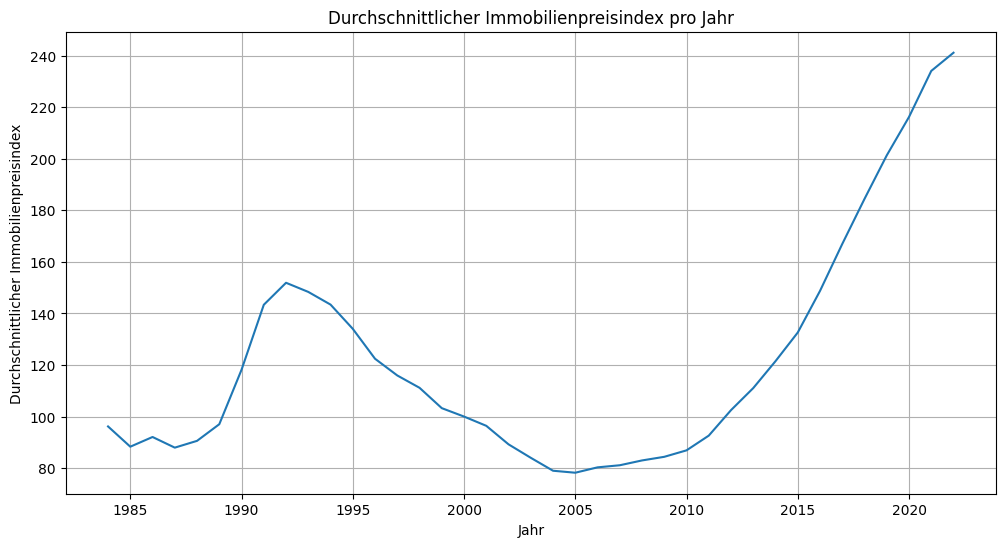

In [160]:
# Berechnung des durchschnittlichen Immobilienpreisindex pro Jahr
avg_immobilienpreisindex_per_year = full_dataset.groupby('Jahr')['Immobilienpreisindex'].mean().reset_index()

# Visualisierung
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_immobilienpreisindex_per_year, x='Jahr', y='Immobilienpreisindex')
plt.title('Durchschnittlicher Immobilienpreisindex pro Jahr')
plt.xlabel('Jahr')
plt.ylabel('Durchschnittlicher Immobilienpreisindex')
plt.grid(True)
plt.show()


### Trendanalyse der Geburtenrate über die Jahre

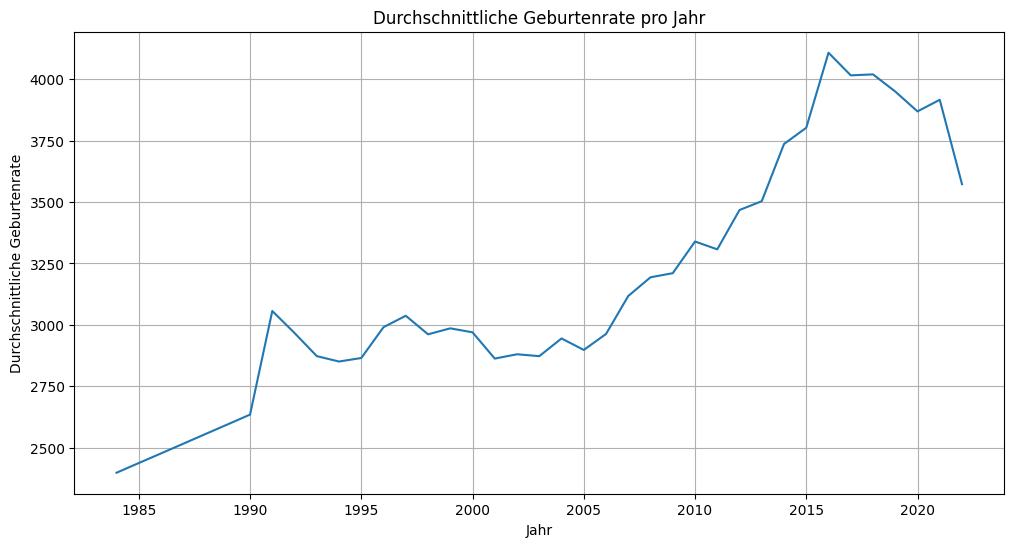

In [161]:
# Trendanalyse der Geburtenrate über die Jahre

# Berechnung des durchschnittlichen Werts für die Geburtenrate pro Jahr
avg_birthrate_per_year = full_dataset.groupby('Jahr')['Geburtenrate'].mean().reset_index()

# Visualisierung
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_birthrate_per_year, x='Jahr', y='Geburtenrate')
plt.title('Durchschnittliche Geburtenrate pro Jahr')
plt.xlabel('Jahr')
plt.ylabel('Durchschnittliche Geburtenrate')
plt.grid(True)
plt.show()

### Scatterplot mit Trendlinie
Veranschaulichung der Korrelation zwischen der Geburtenrate und den Baufertigstellungen anhand einer Regressionsgeraden

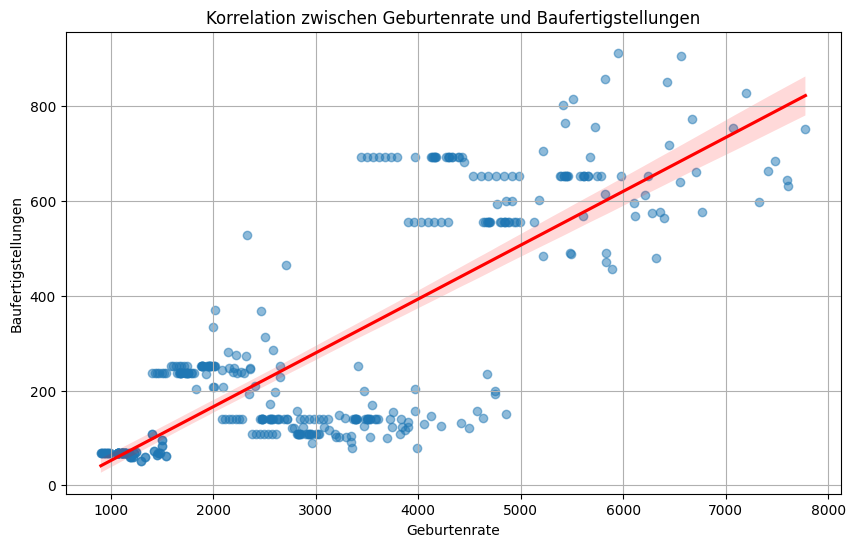

In [146]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Geburtenrate', y='Baufertigstellungen', data=full_dataset, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Korrelation zwischen Geburtenrate und Baufertigstellungen')
plt.xlabel('Geburtenrate')
plt.ylabel('Baufertigstellungen')
plt.grid(True)
plt.show()

### Scatterplot mit Trendlinie
Veranschaulichung der Korrelation zwischen dem Immobilienpreisindex und den Baufertigstellungen

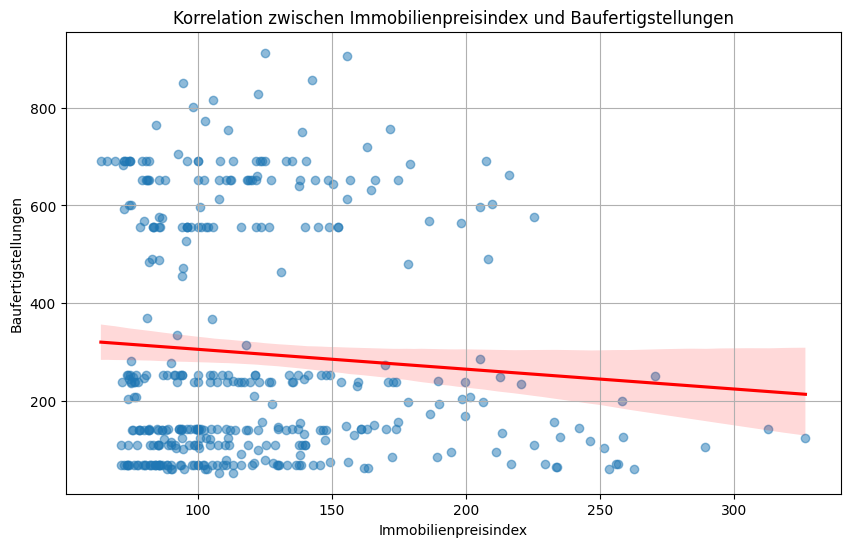

In [156]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Immobilienpreisindex', y='Baufertigstellungen', data=full_dataset, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Korrelation zwischen Immobilienpreisindex und Baufertigstellungen')
plt.xlabel('Immobilienpreisindex')
plt.ylabel('Baufertigstellungen')
plt.grid(True)
plt.show()

### Scatterplot mit Trendlinie
Veranschaulichung der Korrelation zwischen dem Immobilienpreisindex und der Geburtenrate

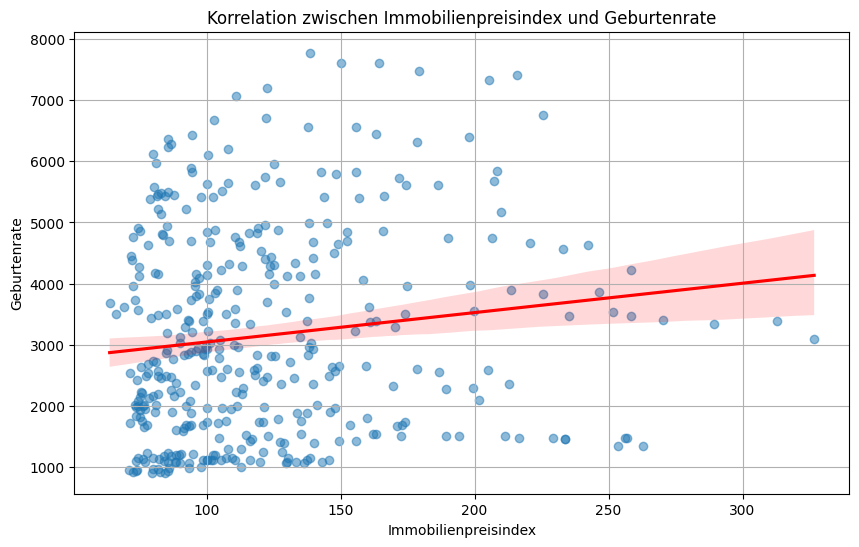

In [298]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Immobilienpreisindex', y='Geburtenrate', data=full_dataset, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Korrelation zwischen Immobilienpreisindex und Geburtenrate')
plt.xlabel('Immobilienpreisindex')
plt.ylabel('Geburtenrate')
plt.grid(True)
plt.show()

### Visualisierungen von Verteilungen

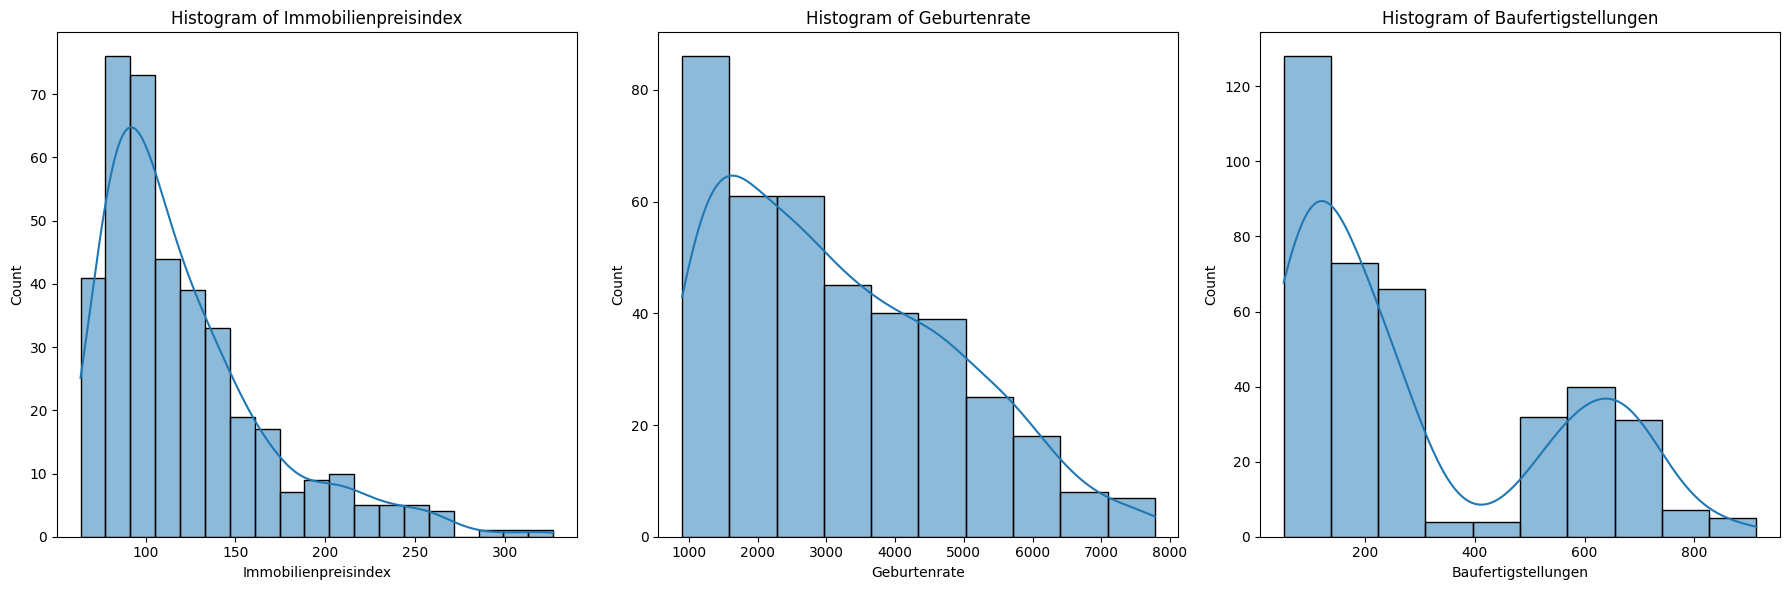

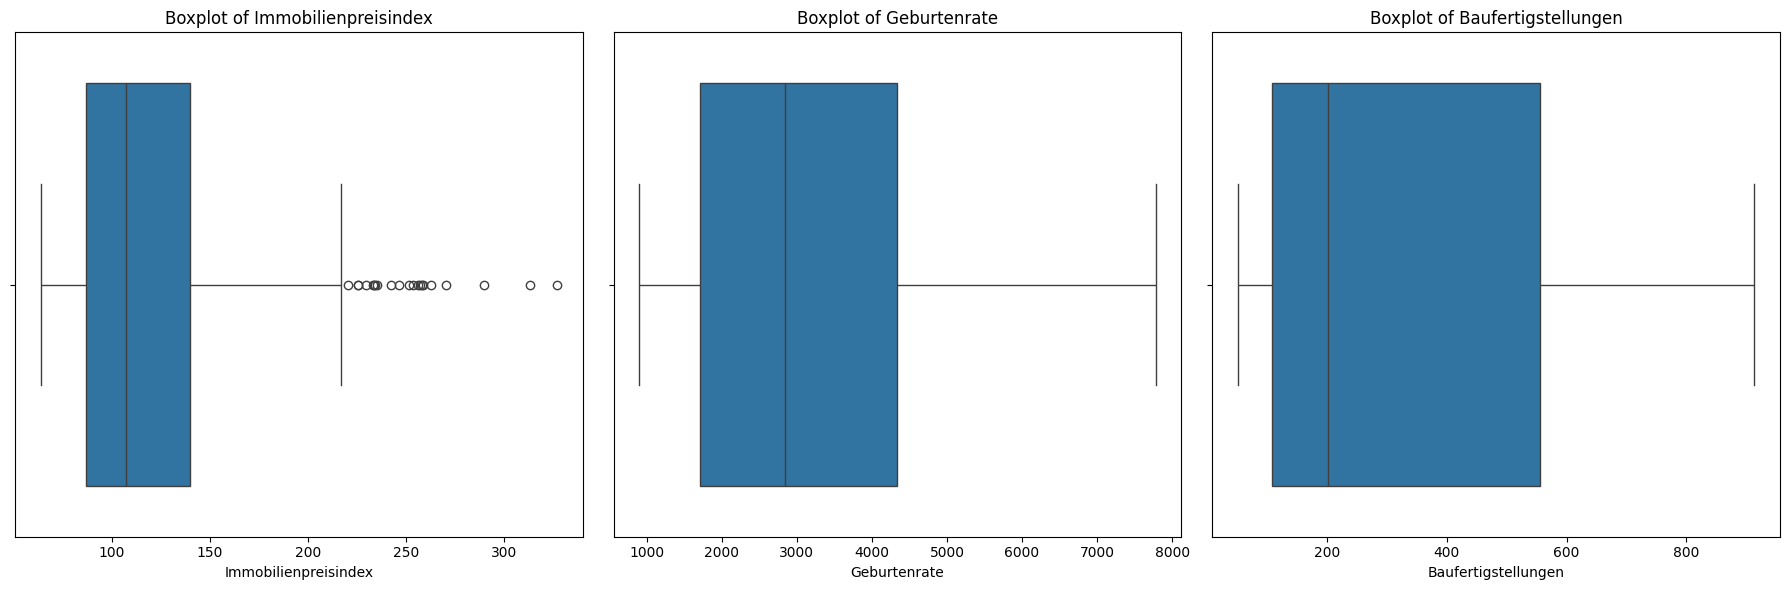

In [299]:
# Laden des Datensets
file_path = 'dataset_merged_cleaned.xlsx'
data = pd.read_excel(file_path)

# Nummerische Spalten
numerical_columns = numeric_columns = [col for col in data.select_dtypes(include=['number']).columns if col != 'Jahr']

# Histogramme erstellen
plt.figure(figsize=(18, 6))
for i, column in enumerate(numeric_columns):
    plt.subplot(1, len(numeric_columns), i + 1)
    sns.histplot(data[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

# Boxplots erstellen
plt.figure(figsize=(18, 6))
for i, column in enumerate(numeric_columns):
    plt.subplot(1, len(numeric_columns), i + 1)
    sns.boxplot(x=data[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

## Training des ML-Modells

### Feature Engineering für Zeitreihen

Wir haben keine spezifischen monatlichen oder vierteljährlichen Daten, aus denen wir saisonale Muster oder Trends ableiten können, aber wir könnten zum Beispiel:

**Lag-Features erstellen**: Bei Zeitreihen sind Lag-Features (Verzögerungen) sehr wichtig. Sie repräsentieren Werte zu früheren Zeitpunkten (z.B. der Immobilienpreisindex des letzten Jahres).

**Rollende Statistiken berechnen**: Wie den gleitenden Durchschnitt oder die Standardabweichung, um Trends zu glätten und Volatilität zu erfassen.

**Differenzierung betrachten**: Dies ist eine Methode zur Stabilisierung der mittleren Änderungsrate einer Zeitreihe, indem die Differenz zwischen aufeinanderfolgenden Beobachtungen berechnet wird.

In [223]:
# Laden des Datensatzes
file_path = 'dataset_merged_cleaned.xlsx'
data_feature_eng1 = pd.read_excel(file_path)

# Konvertierung der 'Jahr'-Spalte in ein Datumsformat
data_feature_eng1['Jahr'] = pd.to_datetime(data_feature_eng1['Jahr'], format='%Y')

# Erstellung von Lag-Features, rollenden Statistiken und einem 5-Jahres gleitenden Durchschnitt
def add_features(group):
    group['Immobilienpreisindex_lag1'] = group['Immobilienpreisindex'].shift(1)
    group['Immobilienpreisindex_rolling_mean'] = group['Immobilienpreisindex'].rolling(window=3).mean()
    group['Immobilienpreisindex_5yr_avg'] = group['Immobilienpreisindex'].rolling(window=5).mean()
    group['Immobilienpreisindex_diff'] = group['Immobilienpreisindex'].diff(periods=1)
    return group

# Anwenden der Funktion auf jede Gruppe
data_feature_eng1 = data_feature_eng1.groupby('Bezirk').apply(add_features)

# Zurücksetzen des Index und Sortieren der Daten
data_feature_eng1 = data_feature_eng1.reset_index(drop=True)
data_feature_eng1 = data_feature_eng1.sort_values(by=['Jahr', 'Bezirk'])

# Anzeige der aktualisierten Daten mit neuen Features
data_feature_eng1.head(30)


,Jahr,Bezirk,Immobilienpreisindex,Geburtenrate,Baufertigstellungen,Immobilienpreisindex_lag1,Immobilienpreisindex_rolling_mean,Immobilienpreisindex_5yr_avg,Immobilienpreisindex_diff
0,1984-01-01,berlin_charlottenburg,79.54,903,68,NaN,NaN,NaN,NaN
39,1984-01-01,berlin_friedrichshain,88.72,2378,109,NaN,NaN,NaN,NaN
78,1984-01-01,berlin_mitte,92.97,2842,141,NaN,NaN,NaN,NaN
117,1984-01-01,berlin_nord,120.38,4536,653,NaN,NaN,NaN,NaN
156,1984-01-01,berlin_ost,79.31,3443,692,NaN,NaN,NaN,NaN
195,1984-01-01,berlin_süd_ost,103.92,3896,556,NaN,NaN,NaN,NaN
234,1984-01-01,berlin_südwest,91.13,1584,252,NaN,NaN,NaN,NaN
273,1984-01-01,berlin_tempelhof_neukölln_kreuzberg,93.84,2085,139,NaN,NaN,NaN,NaN
312,1984-01-01,berlin_west,127.35,1404,238,NaN,NaN,NaN,NaN
351,1984-01-01,berlin_wilmersdorf,84.50,903,68,NaN,NaN,NaN,NaN


### Weiteres Feature Engineering

**Interaktions-Features**: Da Geburtenrate und Baufertigstellungen stark korrelieren, könnte ein Interaktions-Feature zwischen diesen beiden Variablen nützlich sein. Das Produkt aus Geburtenrate und Baufertigstellungen könnte helfen den kombinierten Effekt dieser beiden Variablen auf den Immobilienpreisindex zu erfassen.

**Verhältnis-Features**: Ein weiterer Ansatz könnte sein, das Verhältnis zwischen Geburtenrate und Baufertigstellungen zu berechnen. Ein solches Feature könnte aufzeigen, wie das Verhältnis dieser beiden Faktoren den Immobilienmarkt beeinflusst.

In [300]:
# Erstellung von Interaktions- und Verhältnis-Features
def add_interaction_and_ratio_features(group):
    group['Geburtenrate_Baufertigstellungen_interaction'] = group['Geburtenrate'] * group['Baufertigstellungen']
    group['Geburtenrate_Baufertigstellungen_ratio'] = group['Geburtenrate'] / (group['Baufertigstellungen'] + 1)
    return group

# Anwenden der Funktion auf jede Gruppe
data_feature_eng1 = data_feature_eng1.groupby('Bezirk').apply(add_interaction_and_ratio_features)

# Zurücksetzen des Index
data_feature_eng1 = data_feature_eng1.reset_index(drop=True)

# Speichern des ergänzten Datensatzes 
data_feature_eng1.to_excel('dataset_feature_engineered.xlsx', index=False)

# Anzeige der aktualisierten Daten mit neuen Features
data_feature_eng1.head(20)


,Jahr,Bezirk,Immobilienpreisindex,Geburtenrate,Baufertigstellungen,Immobilienpreisindex_lag1,Immobilienpreisindex_rolling_mean,Immobilienpreisindex_5yr_avg,Immobilienpreisindex_diff,Geburtenrate_Baufertigstellungen_interaction,Geburtenrate_Baufertigstellungen_ratio
0,1984-01-01,berlin_charlottenburg,79.54,903,68,NaN,NaN,NaN,NaN,61404,13.086957
1,1985-01-01,berlin_charlottenburg,72.55,918,68,79.54,NaN,NaN,-6.99,62424,13.304348
2,1986-01-01,berlin_charlottenburg,73.61,932,68,72.55,75.233333,NaN,1.06,63376,13.507246
3,1987-01-01,berlin_charlottenburg,74.09,946,68,73.61,73.416667,NaN,0.48,64328,13.710145
4,1988-01-01,berlin_charlottenburg,80.13,961,68,74.09,75.943333,75.984,6.04,65348,13.927536
5,1989-01-01,berlin_charlottenburg,85.89,975,68,80.13,80.036667,77.254,5.76,66300,14.130435
6,1990-01-01,berlin_charlottenburg,97.75,990,68,85.89,87.923333,82.294,11.86,67320,14.347826
7,1991-01-01,berlin_charlottenburg,130.27,1143,68,97.75,104.636667,93.626,32.52,77724,16.565217
8,1992-01-01,berlin_charlottenburg,137.63,1109,68,130.27,121.883333,106.334,7.36,75412,16.072464
9,1993-01-01,berlin_charlottenburg,133.31,1074,68,137.63,133.736667,116.970,-4.32,73032,15.565217


## Regression mit Random Forest und Hyperparameter-Tuning

### Warum Random Forest?
**Umgang mit verschiedenen Datentypen:** Datensätze, die eine Mischung aus numerischen und kategorialen Daten enthalten, können gut verarbeitet werden.

**Feature-Handling:** Random Forest kann effektiv mit einer großen Anzahl von Features umgehen und ist in der Lage, die wichtigsten Features für die Vorhersage zu identifizieren.

**Nicht-lineare Beziehungen:** Random Forest ist in der Lage, nicht-lineare Beziehungen zwischen Features und Zielvariable zu erkennen, was bei vielen realen Problemen (Preisvorhersage), von Vorteil ist.

**Robustheit gegenüber Overfitting:** Mehrere Entscheidungsbäume werden kombiniert, daher weniger Neigung zu Overfitting.


Erstellung eines Regressionsmodells für die Vorhersage des Immobilienpreisindex, indem ein Random Forest Regressor verwendet wird. Die Daten werden in Trainings- und Testdaten aufgeteilt. Es werden Transformer-Pipelines für kategoriale und numerische Daten erstellt. Dann wird ein Random Forest Modell erstellt und Hyperparameter-Tuning mithilfe von Grid Search mit Kreuzvalidierung durchgeführt, um die besten Hyperparameter-Kombinationen zu finden. Schließlich werden Vorhersagen auf dem Testdatensatz gemacht, und verschiedene Metriken wie der Mean Squared Error (MSE), der Root Mean Squared Error (RMSE), der Mean Absolute Error (MAE) und der R²-Score werden berechnet, um die Leistung des Modells zu bewerten.

In [324]:
# Laden des Datensatzes
file_path = 'dataset_feature_engineered.xlsx'
data = pd.read_excel(file_path)

# Vorbereiten der Daten
X = data.drop(['Immobilienpreisindex'], axis=1)
y = data['Immobilienpreisindex']

# Identifizieren der kategorialen und numerischen Spalten
categorical_features = ['Bezirk']
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# Transformer für kategoriale und numerische Daten
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Zusammenfügen der Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Aufteilen des Datensatzes in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Erstellen des Random Forest Modells
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# Definition des Parametergitters für das Hyperparameter-Tuning des RandomForestRegressors
# n_estimators: Anzahl der Bäume im Wald
# max_depth: Maximale Tiefe der Bäume
# min_samples_split: Minimale Anzahl an Datenpunkten, die benötigt werden, um einen Knoten zu teilen
# min_samples_leaf: Minimale Anzahl an Datenpunkten, die in einem Blattknoten sein müssen
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Grid Search mit Kreuzvalidierung
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Ergebnisse der Kreuzvalidierung anzeigen
cv_results = grid_search.cv_results_
mean_scores = cv_results['mean_test_score']
print("Kreuzvalidierte Performance (MSE) für die ersten 10 Hyperparameter-Kombinationen:")
for params, score in zip(cv_results['params'][:10], mean_scores[:10]):
    print(params, ":", -score)
print("Beste Parameterkombination:", grid_search.best_params_)

# Bestes Modell auswählen
best_model = grid_search.best_estimator_

# Vorhersagen auf dem Testdatensatz
y_pred = best_model.predict(X_test)

# Berechnen der Metriken für den Testdatensatz
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = test_mse ** 0.5
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
print(f"Test Mean Squared Error (MSE): {test_mse}")
print(f"Test Root Mean Squared Error (RMSE): {test_rmse}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")
print(f"Test R² Score: {test_r2}")

Kreuzvalidierte Performance (MSE) für die ersten 10 Hyperparameter-Kombinationen:
{'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100} : 36.808470360610876
{'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200} : 36.53721886987093
{'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300} : 37.552550049747694
{'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100} : 39.27814297425926
{'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200} : 40.2197434558643
{'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 300} : 39.62004315660218
{'reg

Der Test MSE ist höher als die meisten MSE-Werte aus der Kreuzvalidierung. Ein höherer MSE auf dem Testdatensatz kann auf eine Überanpassung (Overfitting) während des Trainings hinweisen. Das Modell hat im Training besser performt als bei der Vorhersage.  
--> Überprüfung und mögliche Reduktion der Anzahl der Features, um die Komplexität des Modells zu reduzieren.

### Overfitting vermeiden: Modell mit weniger Features

In [343]:
# Laden des Datensatzes
file_path = 'dataset_feature_engineered.xlsx'
data = pd.read_excel(file_path)

# Vorbereiten der Daten
X = data.drop(['Immobilienpreisindex', 'Immobilienpreisindex_lag1', 'Geburtenrate_Baufertigstellungen_ratio'], axis=1)
y = data['Immobilienpreisindex']

# Identifizieren der kategorialen und numerischen Spalten
categorical_features = ['Bezirk']
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# Transformer für kategoriale und numerische Daten
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Zusammenfügen der Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Aufteilen des Datensatzes in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Erstellen des Random Forest Modells
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# Definition des Parametergitters für das Hyperparameter-Tuning des RandomForestRegressors
# n_estimators: Anzahl der Bäume im Wald
# max_depth: Maximale Tiefe der Bäume
# min_samples_split: Minimale Anzahl an Datenpunkten, die benötigt werden, um einen Knoten zu teilen
# min_samples_leaf: Minimale Anzahl an Datenpunkten, die in einem Blattknoten sein müssen
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Grid Search mit Kreuzvalidierung
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Ergebnisse der Kreuzvalidierung anzeigen
cv_results = grid_search.cv_results_
mean_scores = cv_results['mean_test_score']
print("Kreuzvalidierte Performance (MSE) für die ersten 10 Hyperparameter-Kombinationen:")
for params, score in zip(cv_results['params'][:10], mean_scores[:10]):
    print(params, ":", -score)
print("Beste Parameterkombination:", grid_search.best_params_)

# Bestes Modell auswählen
best_model = grid_search.best_estimator_

# Vorhersagen auf dem Testdatensatz
y_pred = best_model.predict(X_test)

# Berechnen der Metriken für den Testdatensatz
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = test_mse ** 0.5
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
print(f"Test Mean Squared Error (MSE): {test_mse}")
print(f"Test Root Mean Squared Error (RMSE): {test_rmse}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")
print(f"Test R² Score: {test_r2}")

Kreuzvalidierte Performance (MSE) für die ersten 10 Hyperparameter-Kombinationen:
{'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100} : 37.66769179332511
{'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200} : 37.88042132949647
{'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300} : 37.73832381590996
{'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100} : 42.34237960972929
{'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200} : 41.22109477161867
{'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 300} : 42.813562056932675
{'reg

### Visualisierung der Ergebnisse

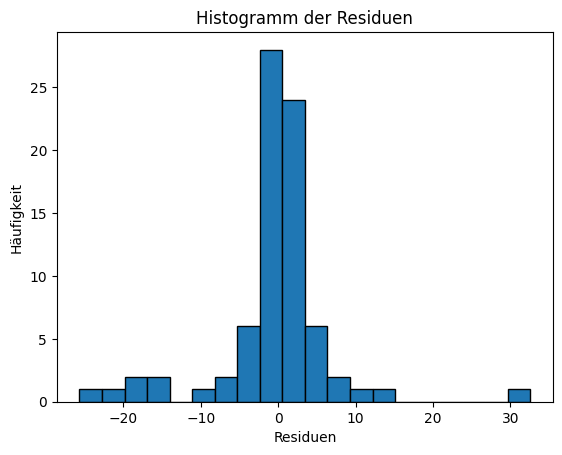

In [325]:
# Berechnen der Residuen (Tatsächliche Werte - Vorhersagen)
residuen = y_test - y_pred

# Erstellen eines Histogramms der Residuen
plt.hist(residuen, bins=20, edgecolor='black')
plt.title('Histogramm der Residuen')
plt.xlabel('Residuen')
plt.ylabel('Häufigkeit')
plt.show()

### Scatterplot der tatsächlichen vs. vorhergesagten Werte

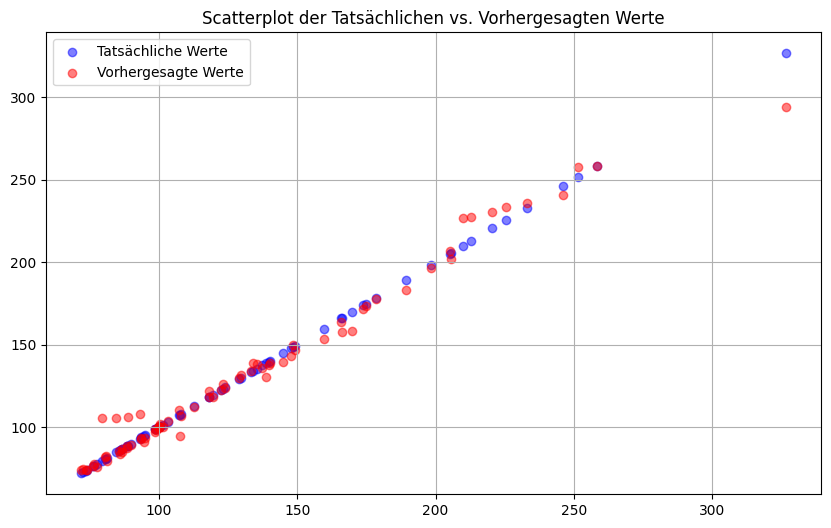

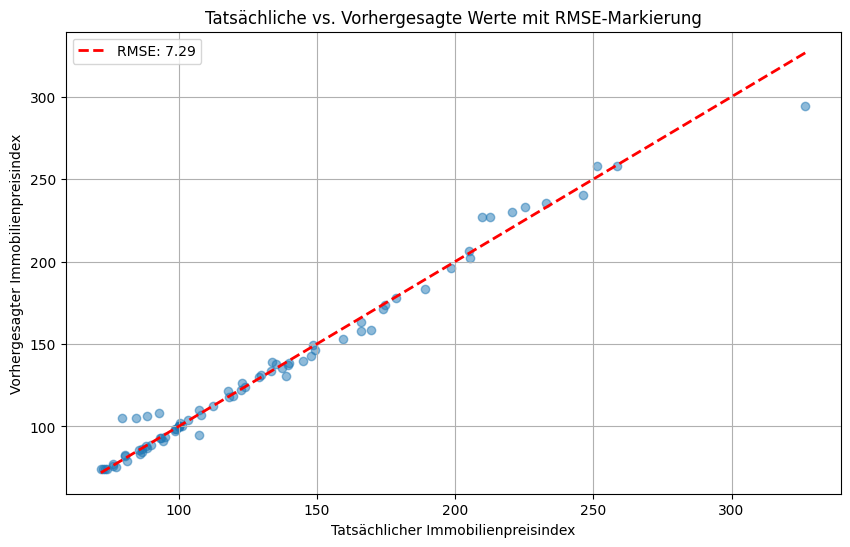

In [329]:
# Erstellen des Streudiagramms 1
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test, alpha=0.5, label='Tatsächliche Werte', color='blue')
plt.scatter(y_test, y_pred, alpha=0.5, label='Vorhergesagte Werte', color='red')
plt.legend()
plt.title("Scatterplot der Tatsächlichen vs. Vorhergesagten Werte")
plt.grid(True)
plt.show()

# Berechnen des RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Erstellen des Streudiagramms 2
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label=f'RMSE: {rmse:.2f}')
plt.xlabel('Tatsächlicher Immobilienpreisindex')
plt.ylabel('Vorhergesagter Immobilienpreisindex')
plt.legend()
plt.title('Tatsächliche vs. Vorhergesagte Werte mit RMSE-Markierung')
plt.grid(True)
plt.show()

## Predictions: Berlin Mitte in 2023

### Werte von Berlin Mitte anzeigen lassen für die letzten Jahre 

In [307]:
# Laden des Datensatzes
file_path = 'dataset_feature_engineered.xlsx'
data = pd.read_excel(file_path)

# Filtern des Datensatzes für den Bezirk 'berlin_mitte' und die Jahre 2016-2022
berlin_mitte_data = data[(data['Bezirk'] == 'berlin_mitte') & 
                         (data['Jahr'].dt.year >= 2016) & 
                         (data['Jahr'].dt.year <= 2022)]

# Anzeige der gefilterten Daten
berlin_mitte_data.head(10)


,Jahr,Bezirk,Immobilienpreisindex,Geburtenrate,Baufertigstellungen,Immobilienpreisindex_lag1,Immobilienpreisindex_rolling_mean,Immobilienpreisindex_5yr_avg,Immobilienpreisindex_diff,Geburtenrate_Baufertigstellungen_interaction,Geburtenrate_Baufertigstellungen_ratio
110,2016-01-01,berlin_mitte,165.91,4855,150,147.36,150.956667,141.582,18.55,728250,32.152318
111,2017-01-01,berlin_mitte,189.96,4746,192,165.91,167.743333,154.544,24.05,911232,24.590674
112,2018-01-01,berlin_mitte,206.57,4750,198,189.96,187.480000,169.880,16.61,940500,23.869347
113,2019-01-01,berlin_mitte,220.59,4668,234,206.57,205.706667,186.078,14.02,1092312,19.863830
114,2020-01-01,berlin_mitte,232.96,4572,156,220.59,220.040000,203.198,12.37,713232,29.121019
115,2021-01-01,berlin_mitte,242.41,4628,143,232.96,231.986667,218.498,9.45,661804,32.138889
116,2022-01-01,berlin_mitte,258.47,4222,125,242.41,244.613333,232.200,16.06,527750,33.507937


### Berechnung der Features für 2023

In [308]:
# Laden des Datensatzes
file_path = 'dataset_feature_engineered.xlsx'
data = pd.read_excel(file_path)

# Filtern des Datensatzes für Berlin Mitte und Erstellen einer Kopie
berlin_mitte_data = data[data['Bezirk'] == 'berlin_mitte'].copy()

# Sortieren des Datensatzes nach Jahr
berlin_mitte_data.sort_values(by='Jahr', inplace=True)

# Berechnen des 3-Jahres- und 5-Jahres-gleitenden Durchschnitts
berlin_mitte_data['Immobilienpreisindex_rolling_mean'] = berlin_mitte_data['Immobilienpreisindex'].rolling(window=3).mean()
berlin_mitte_data['Immobilienpreisindex_5yr_avg'] = berlin_mitte_data['Immobilienpreisindex'].rolling(window=5).mean()

# Berechnen der jährlichen Differenz des Immobilienpreisindex
berlin_mitte_data['Immobilienpreisindex_diff'] = berlin_mitte_data['Immobilienpreisindex'].diff(periods=1)

# Anzeigen der letzten berechneten Werte für 2023
latest_values = berlin_mitte_data.tail(1)
print("Geschätzte Werte für Berlin Mitte im Jahr 2023:")
print("Immobilienpreisindex_rolling_mean:", latest_values['Immobilienpreisindex_rolling_mean'].values[0])
print("Immobilienpreisindex_5yr_avg:", latest_values['Immobilienpreisindex_5yr_avg'].values[0])
print("Immobilienpreisindex_diff:", latest_values['Immobilienpreisindex_diff'].values[0])

Geschätzte Werte für Berlin Mitte im Jahr 2023:
Immobilienpreisindex_rolling_mean: 244.61333333333334
Immobilienpreisindex_5yr_avg: 232.2
Immobilienpreisindex_diff: 16.06000000000003


### Werte für 2023 eintragen um den Immobilienpreisindex zu berechnen

In [323]:
# Neue Daten für die Vorhersage
new_data = pd.DataFrame({
    'Jahr': pd.to_datetime(['2023']),
    'Bezirk': ['berlin_mitte'],  # Gewünschten Bezirk hier eintragen
    'Geburtenrate': [4100],  # Geschätzten Wert hier hinzufügen
    'Baufertigstellungen': [130],  # Geschätzten Wert hier hinzufügen
    'Immobilienpreisindex_lag1': [258.47],  # Wert des Index im Vorjahr
    'Immobilienpreisindex_rolling_mean': [244.61],  # Gleitender Durchschnitt
    'Immobilienpreisindex_5yr_avg': [232.2],  # 5-Jahres-Durchschnitt
    'Immobilienpreisindex_diff': [16.06],  # Differenz zum Vorjahr
    'Geburtenrate_Baufertigstellungen_interaction': [533000],  # Berechneter Wert
    'Geburtenrate_Baufertigstellungen_ratio': [31.53]  # Berechneter Wert
})

# Vorhersage machen mit der bereits trainierten Pipeline
predicted_price_index = best_model.predict(new_data)
print("Vorhergesagter Immobilienpreisindex für das Jahr 2023 und gewählten Bezirk:", predicted_price_index[0])


Vorhergesagter Immobilienpreisindex für das Jahr 2023 und gewählten Bezirk: 256.1300999999999


### Vergleich Basismodell: Lineare Regression

In [344]:
# Laden des Datensatzes
data = pd.read_excel('dataset_feature_engineered.xlsx') 

data['Jahr'] = data['Jahr'].dt.year

# Datenvorbereitung: Auswahl relevanter Spalten, Umgang mit fehlenden Werten, etc.
selected_columns = ['Jahr', 'Immobilienpreisindex', 'Geburtenrate', 'Baufertigstellungen'] 
data = data[selected_columns].dropna()

# Aufteilung in Features (X) und Zielvariable (y)
X = data.drop('Immobilienpreisindex', axis=1)
y = data['Immobilienpreisindex']

# Aufteilung in Trainings- und Testset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Erstellen des linearen Regressionsmodells
model = LinearRegression()

# Training des Modells
model.fit(X_train, y_train)

# Vorhersagen mit dem Testset
y_pred = model.predict(X_test)

# Modellbewertung
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'R²-Score: {r2}')

RMSE: 43.64663311044068
R²-Score: 0.33267420571423423


## Verbesserungsansätze

- Weitere Modelle ausprobieren wie Gradient Boosting Regression (z.B. XGBoost, LightGBM)
- Mehr Features integrieren
- Feature Importance messen (mit Random Forest)
- Feature Engineering anpassen
- Bessere Datenergänzung bei den Baufertigstellungen durch Interpolation z. Bsp.